In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#plot_n_b_psth.ipynb
#plot neural and behavior psth

import scipy.io as sio
import scipy.stats as sio_stat
import scipy.interpolate
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt 

import os
import pickle
import sys
import copy

import time
import pylab as pl
from IPython import display

from bmi_dynamics_code import behavior_co_obs as bmi_b
from bmi_dynamics_code import data_for_v as preeyacode
from bmi_dynamics_code import util as bmi_util

import timeit
from sklearn import decomposition as skl_decomp

%matplotlib notebook

In [3]:
%matplotlib notebook

In [101]:
# data_dir = '/Users/vivekathalye/Dropbox/Code/preeya_co_obstacle'
save_dir = r'D:\Dropbox\BMI_co_obs_paper\data\vivek\command_compare'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

home_dir = r'D:\Dropbox\Code\preeya_co_obstacle'
data_dir = r'D:\Dropbox\Data\preeya_co_obstacle'
data_path = os.path.join(data_dir, 'for_v_df.pkl')
print(os.path.exists(data_path))
d = pickle.load(open(data_path))

#UNPACK: 
decoder = d['decoder']
pre = d['pre']
num_targets = d['num_targets']
sample_period = d['sample_period']
target_hold_time = d['target_hold_time']
num_neurons = d['num_neurons']
target_color = d['target_color']
obs_big = d['obs_big']
obs_small = d['obs_small']
target_r_task = d['target_r_task'] #target_r_task = {0:1.7, 1:2.0}
cursor_r = d['cursor_r']
target_r_eff = d['target_r_eff']
target_pos = d['target_pos']
target_angle = np.arctan2(target_pos[:,1], target_pos[:,0])
target_dist = np.linalg.norm(target_pos, axis=1)
obs_pos = d['obs_pos']

tc_meta = d['tc_meta']
task_list = d['task_list']
num_tasks = len(task_list)
task2idx = d['task2idx']
idx2task = bmi_util.invert_dic(task2idx)
task2tc = d['task2tc']
tc_list = d['tc_list']
df = d['df']
df_label = d['df_label']

task_color = ['k', 'r']

True


In [102]:
#Pre-processing: 

#Trial boundaries:
trial_start = np.where((df['bin']==-10.0))[0]
trial_stop = np.where((df['trial_stop']==1))[0]
trial_bound = np.vstack((trial_start,trial_stop)).T
num_trials = trial_bound.shape[0]

#-----------------------------------------------------------------------------------------------
#Time till end of trial: 
df['bin_end'] = 0
df['prog'] = 0

for bnd in trial_bound:
    bin_data = df['bin'][bnd[0]:bnd[1]+1]
    last_bin = bin_data.iloc[-1]
    bin_end = last_bin-bin_data
    prog = bin_data/last_bin
    #ASSIGN:
    df['bin_end'][bnd[0]:bnd[1]+1] = bin_end
    df['prog'][bnd[0]:bnd[1]+1] = prog
    
#-----------------------------------------------------------------------------------------------    
#Cond Trial number
for task in range(num_tasks):
    for target in range(num_targets):
        cond_sel = (df['task']==task) & (df['target']==target)
        trial_start = (df['bin']==0) & cond_sel 
        trial_stop = (df['bin_end']==0) & cond_sel
        trial_bnd = np.vstack((np.where(trial_start)[0], np.where(trial_stop)[0]))
        for i,bnd in enumerate(trial_bnd.T):
            print(i, bnd)
            df.loc[bnd[0]:bnd[1], 'trial_cond'] = i
    
#-----------------------------------------------------------------------------------------------    
#Polar coordinates: 
# 1) Convert stuff to polar, 2) center angles at target angle, 3) calculate distance to target
# 1) Convert stuff to polar
df['p_mag'], df['p_angle'] = bmi_b.cartesian2polar(df['kin_py'], df['kin_px'])
df['v_mag'], df['v_angle'] = bmi_b.cartesian2polar(df['kin_vy'], df['kin_vx'])
df['u_p_mag'], df['u_p_angle'] = bmi_b.cartesian2polar(df['u_py'], df['u_px'])
df['u_v_mag'], df['u_v_angle'] = bmi_b.cartesian2polar(df['u_vy'], df['u_vx'])
# 2) Center @ target angle: 
d_list = ['p_angle', 'v_angle', 'u_p_angle', 'u_v_angle']
for d in d_list:
    data = df[d]
    zeros = np.zeros(data.shape)
    t_angle = target_angle[df['target'].astype(int)]
    df[d+'_ctr'] = bmi_b.center_angle(df[d], zeros, t_angle)
# 3) distance to target
error = df.loc[:, 'kin_px':'kin_py']-target_pos[df['target'].astype(int),:]
df['d2target'] = np.linalg.norm(error,ord=2,axis=1)
df['x_error'] = error.loc[:,'kin_px']
df['y_error'] = error.loc[:,'kin_py']    

#-----------------------------------------------------------------------------------------------
#BINNING: 
#1) magnitude bins: 
num_mag_bins = 4
mag_bin_perc = np.array([0,25,50,75,100])
mag_data = df['u_v_mag']
#mag_data = df['u_v_mag'][df['bin']>=0] - we didn't do this, because we want to be able to bin all data, negative bins
mag_bin = np.percentile(mag_data, mag_bin_perc)
mag_bin_edges = np.vstack((mag_bin[0:-1], mag_bin[1:]))
mag_bin_c = mag_bin_edges.mean(axis=0)

#2) angle bins: 
num_angle_bins = 8
T0_angle = -3*(2*np.pi)/8
angle_bin_c = np.linspace(T0_angle, T0_angle+np.pi*2, num=num_angle_bins+1, endpoint=True)
# angle_bin_c[angle_bin_c > np.pi] = angle_bin_c[angle_bin_c > np.pi] - 2*np.pi #center at angle 0 instead of 180
angle_bin = angle_bin_c-np.pi*2/16.0
# angle_bin[angle_bin < -np.pi] = angle_bin[angle_bin < -np.pi] + 2*np.pi
angle_bin_edges = np.vstack((angle_bin[0:-1], angle_bin[1:]))

#center angles for binning: 
angle_center_for_binning = (angle_bin[-1]+angle_bin[0])/2.0
print('angle_center:', angle_center_for_binning*180/np.pi)

angle_vars = ['p_angle', 'v_angle', 'u_p_angle', 'u_v_angle']
for d in angle_vars:
    df[d] = bmi_b.center_angle_v2(np.array(df[d]), angle_center_for_binning)
print('min centered angle:', np.min(df['u_v_angle'])*180/np.pi)
print('max centered angle:', np.max(df['u_v_angle'])*180/np.pi)

#BIN DATA: 
bin_dic = {}
bin_dic[0] = mag_bin_edges
bin_dic[1] = angle_bin_edges

data2bin = np.array(df[['u_v_mag','u_v_angle']])
bin_r, hist_r = bmi_b.bin_vec_data(data2bin, bin_dic)
df['u_v_mag_bin']=bin_r[:,0]
df['u_v_angle_bin']=bin_r[:,1]

c:\anaconda3\envs\py2\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\anaconda3\envs\py2\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(0, array([10, 54], dtype=int64))
(1, array([65, 96], dtype=int64))
(2, array([107, 137], dtype=int64))
(3, array([148, 169], dtype=int64))
(4, array([180, 210], dtype=int64))
(5, array([221, 252], dtype=int64))
(6, array([263, 293], dtype=int64))
(0, array([304, 349], dtype=int64))
(1, array([360, 411], dtype=int64))
(2, array([422, 450], dtype=int64))
(3, array([461, 522], dtype=int64))
(4, array([533, 574], dtype=int64))
(5, array([585, 633], dtype=int64))
(6, array([644, 678], dtype=int64))
(7, array([689, 726], dtype=int64))
(0, array([737, 782], dtype=int64))
(1, array([793, 826], dtype=int64))
(2, array([837, 876], dtype=int64))
(3, array([887, 948], dtype=int64))
(4, array([ 959, 1003], dtype=int64))
(5, array([1014, 1053], dtype=int64))
(6, array([1064, 1101], dtype=int64))
(7, array([1112, 1141], dtype=int64))
(0, array([1152, 1176], dtype=int64))
(1, array([1187, 1232], dtype=int64))
(2, array([1243, 1300], dtype=int64))
(3, array([1311, 1341], dtype=int64))
(4, array([1352,

<IPython.core.display.Javascript object>


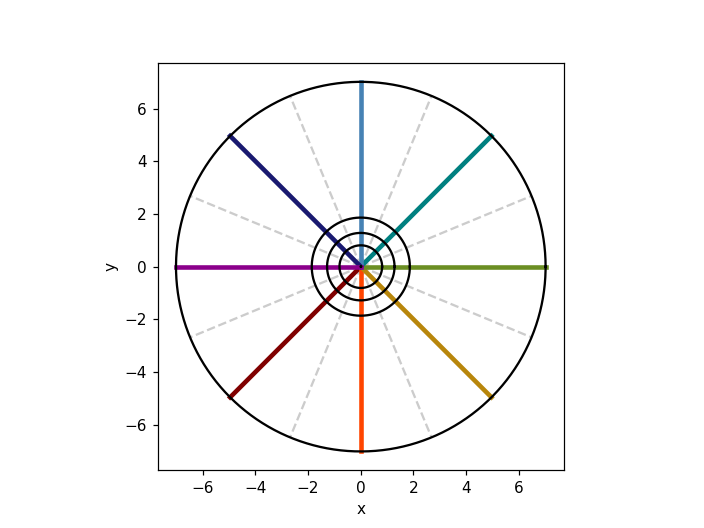

In [6]:
bmi_b.plot_polar_bins(angle_bin_edges, mag_bin_edges, target_color)

### Visualize Binning: 

In [7]:
def plot_command_bin(): 
    bmi_b.plot_polar_bins(angle_bin_edges, mag_bin_edges, target_color)

<IPython.core.display.Javascript object>


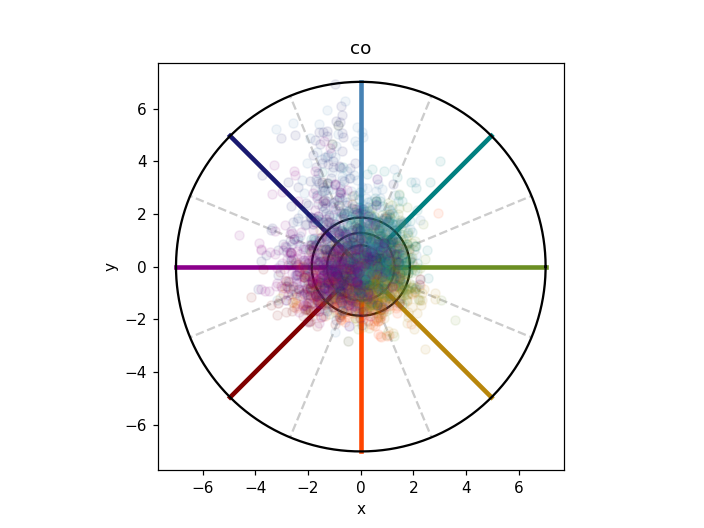

<IPython.core.display.Javascript object>


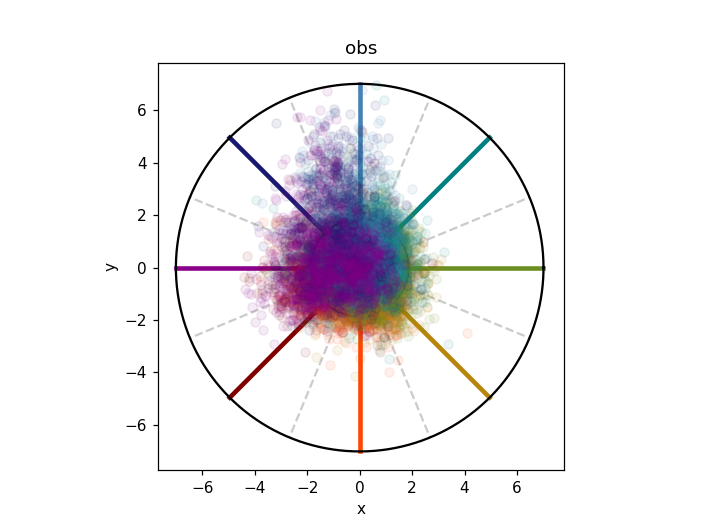

Text(0,0.5,'y')

In [8]:
for task in range(num_tasks):
    plt.figure()
    plt.title(task_list[task])    
    plot_command_bin()
#     bmi_b.plot_polar_bins(angle_bin_edges, mag_bin_edges, target_color)
    for target in range(num_targets):
            task_sel = (df['task'] == task)
            target_sel = (df['target'] == target)
            sel = task_sel & target_sel
            
            x = df['u_vx'][sel]
            y = df['u_vy'][sel]
            plt.scatter(x, y,alpha=0.08,color=target_color[target],zorder=1000)

plt.axis('square')
plt.xlabel('x')
plt.ylabel('y')

<IPython.core.display.Javascript object>


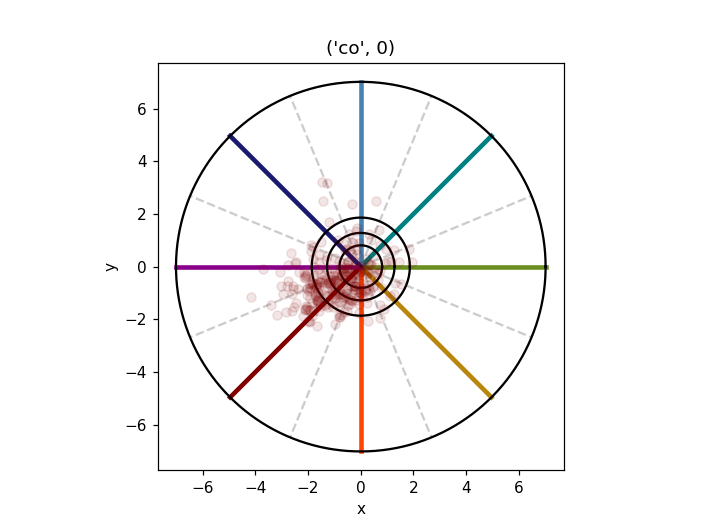

<IPython.core.display.Javascript object>


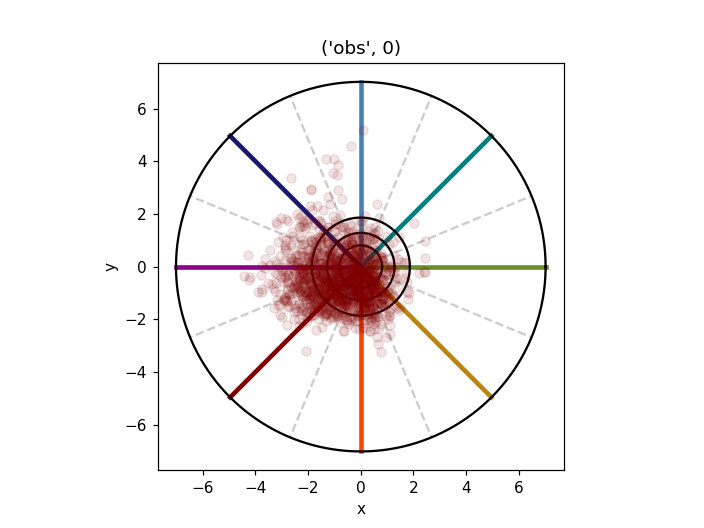

<IPython.core.display.Javascript object>


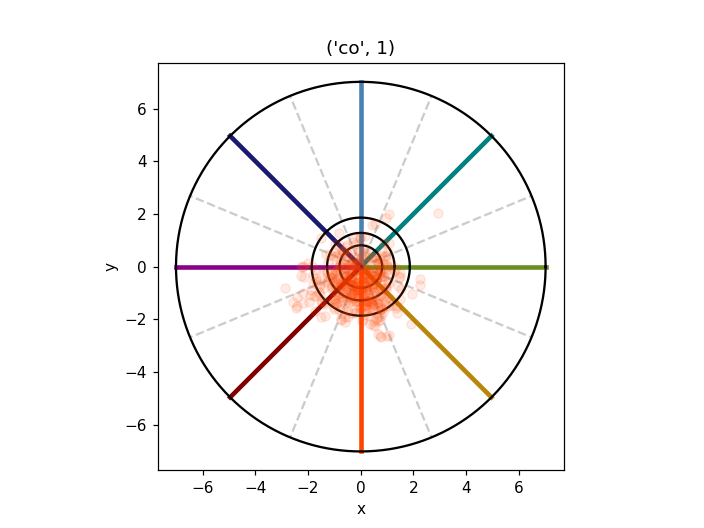

<IPython.core.display.Javascript object>


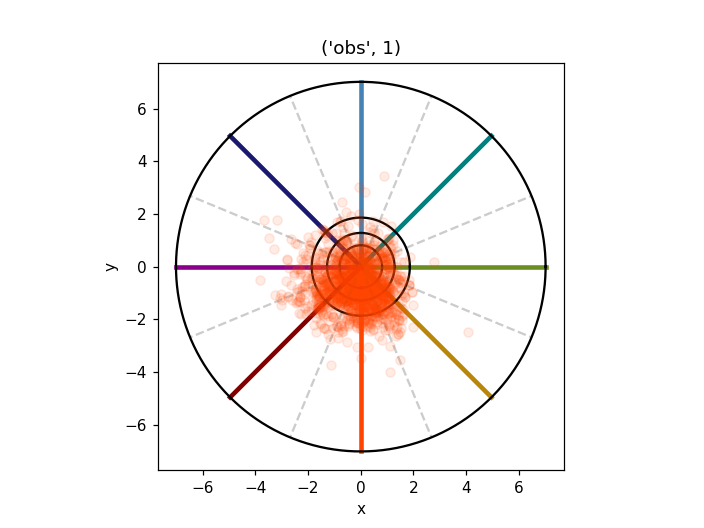

<IPython.core.display.Javascript object>


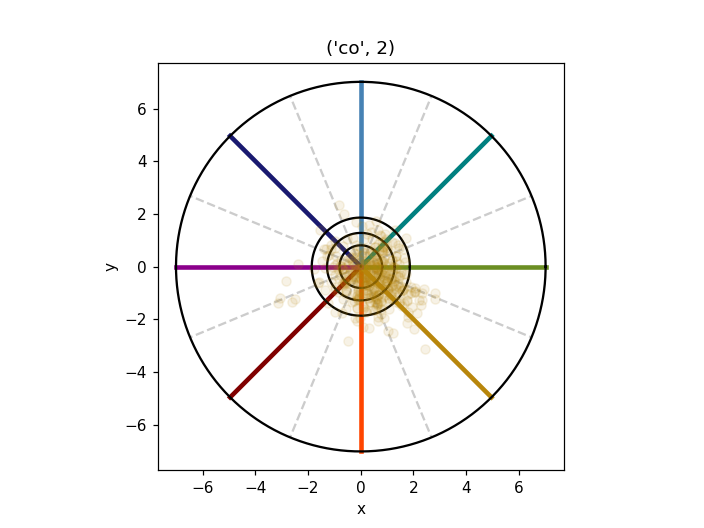

<IPython.core.display.Javascript object>


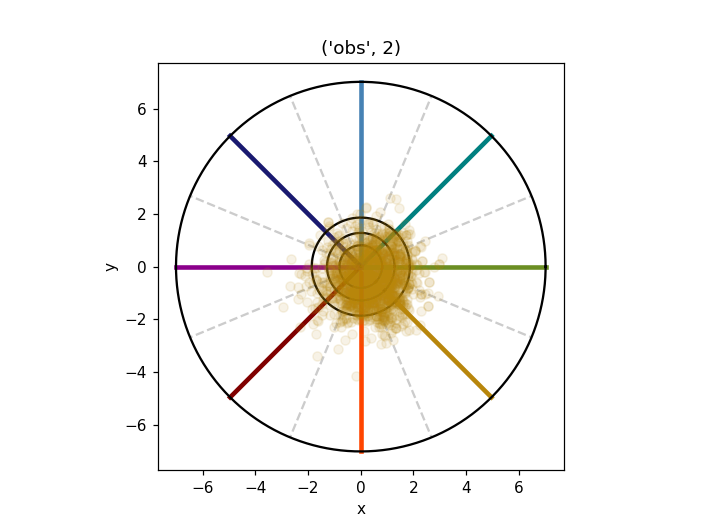

<IPython.core.display.Javascript object>


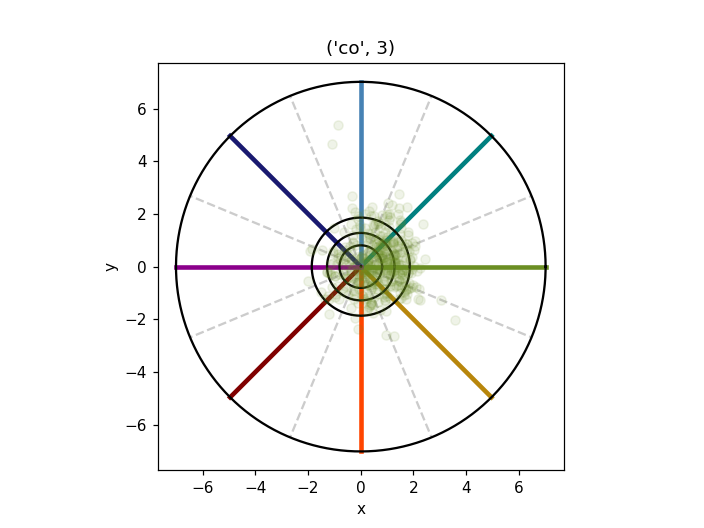

<IPython.core.display.Javascript object>


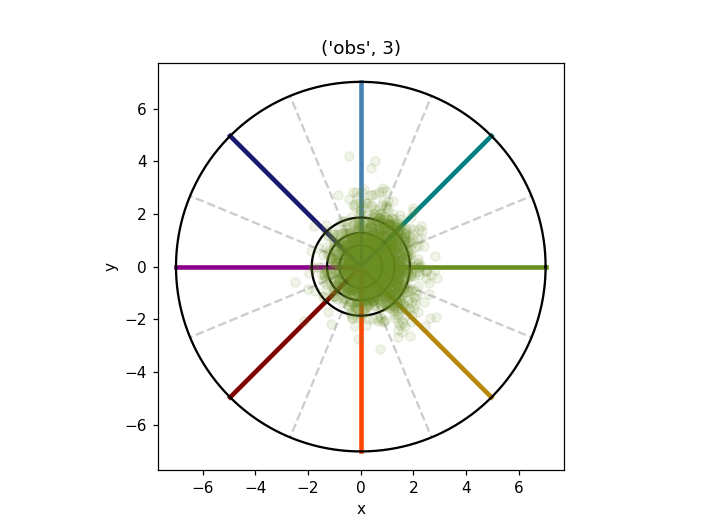

<IPython.core.display.Javascript object>


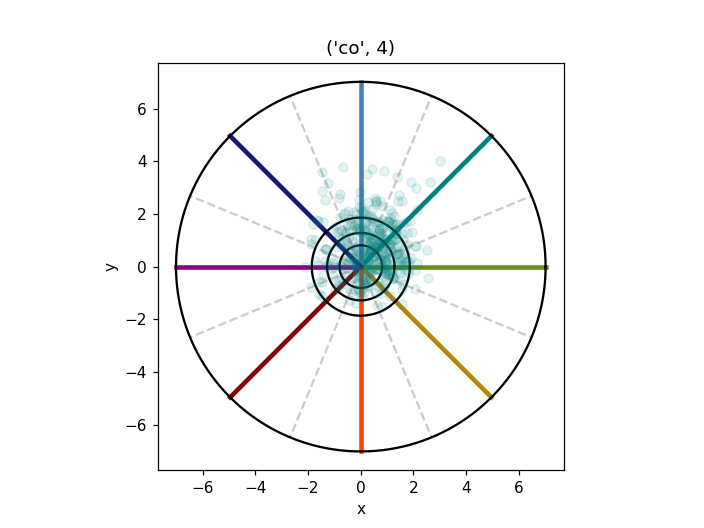

<IPython.core.display.Javascript object>


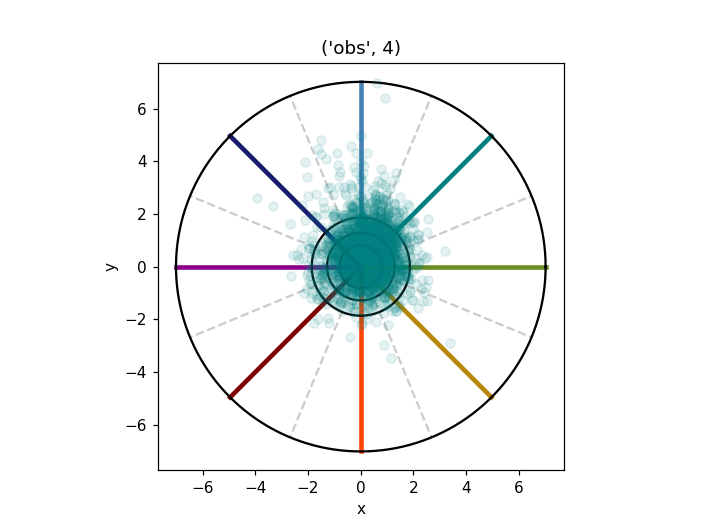

<IPython.core.display.Javascript object>


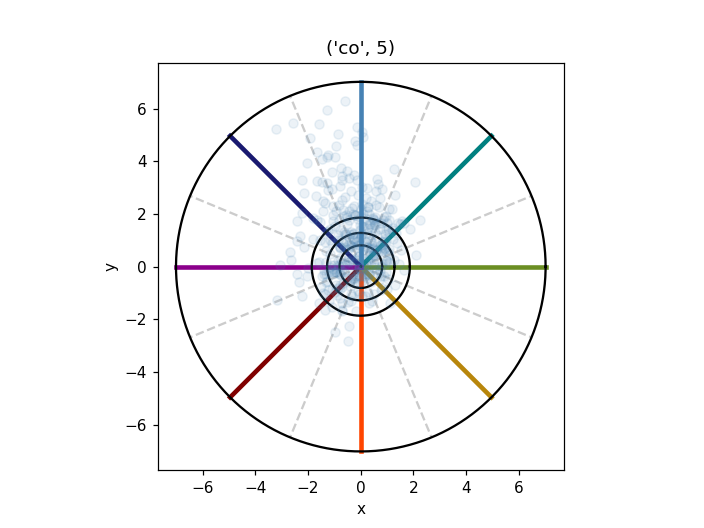

<IPython.core.display.Javascript object>


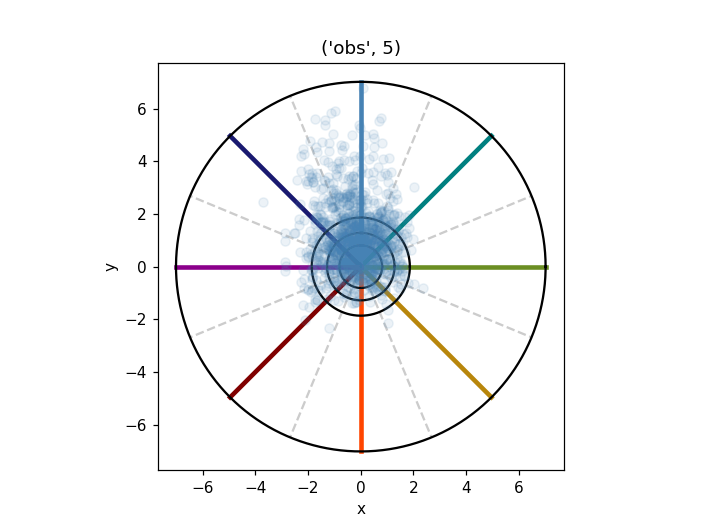

<IPython.core.display.Javascript object>


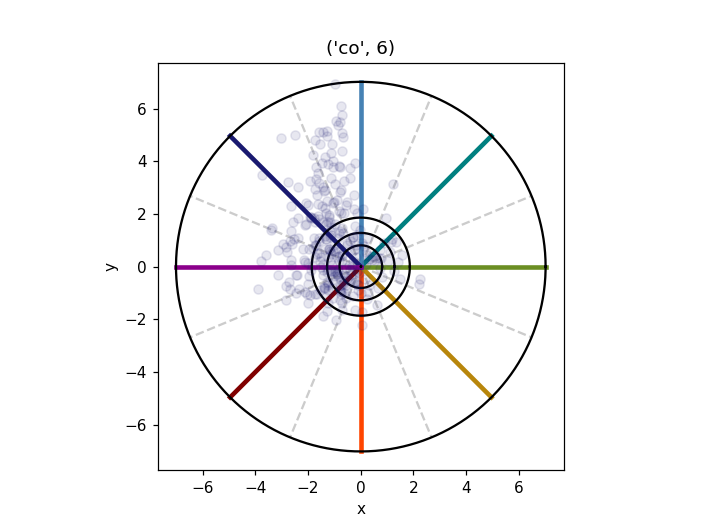

<IPython.core.display.Javascript object>


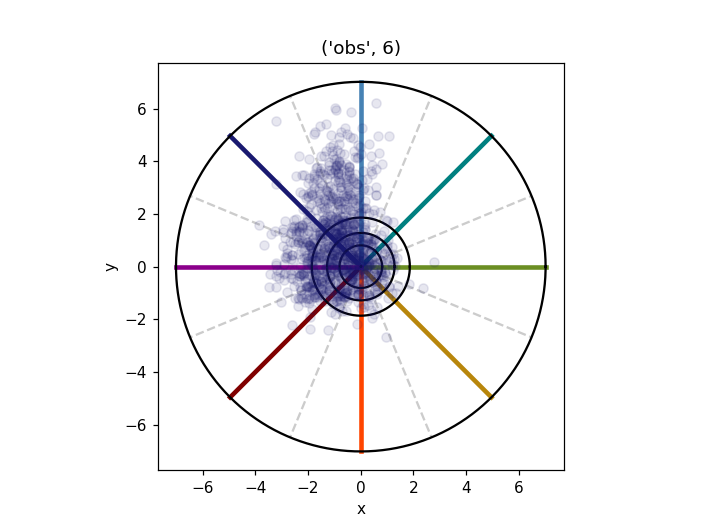

<IPython.core.display.Javascript object>


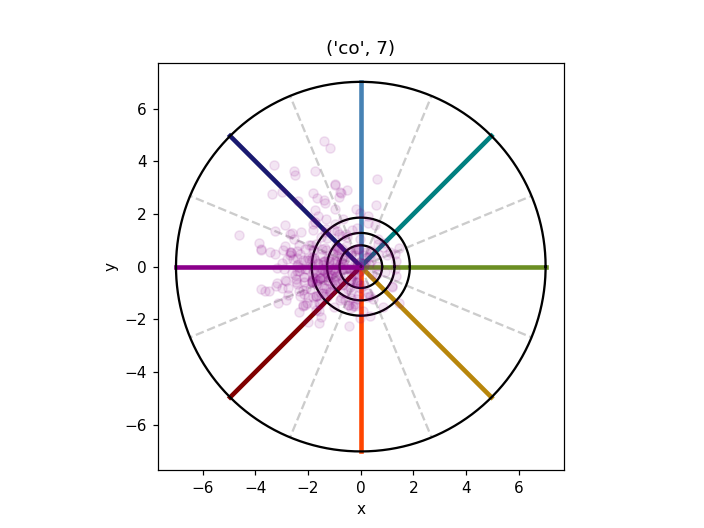

<IPython.core.display.Javascript object>


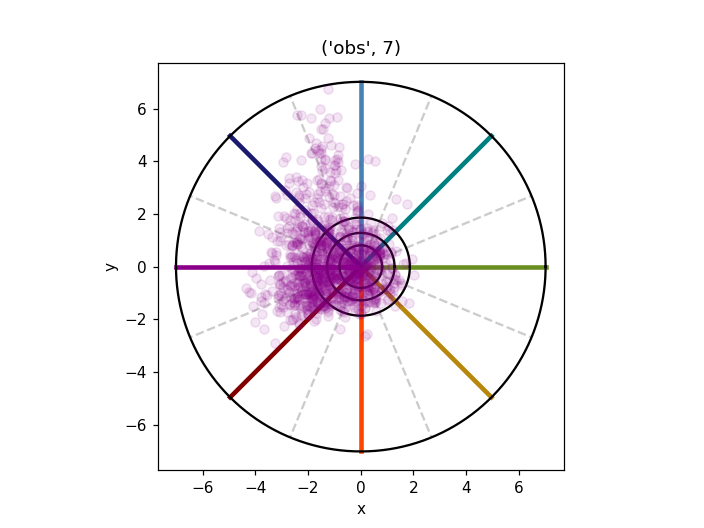

Text(0,0.5,'y')

In [9]:
for target in range(num_targets): #[0]
    for task in range(num_tasks):
        plt.figure()
        plt.title((task_list[task], target))    
        plot_command_bin()        
        
        task_sel = (df['task'] == task)
        target_sel = (df['target'] == target)
        sel = task_sel & target_sel

        x = df['u_vx'][sel]
        y = df['u_vy'][sel]
        plt.scatter(x, y,alpha=0.1,color=target_color[target])

plt.axis('square')
plt.xlabel('x')
plt.ylabel('y')

<IPython.core.display.Javascript object>


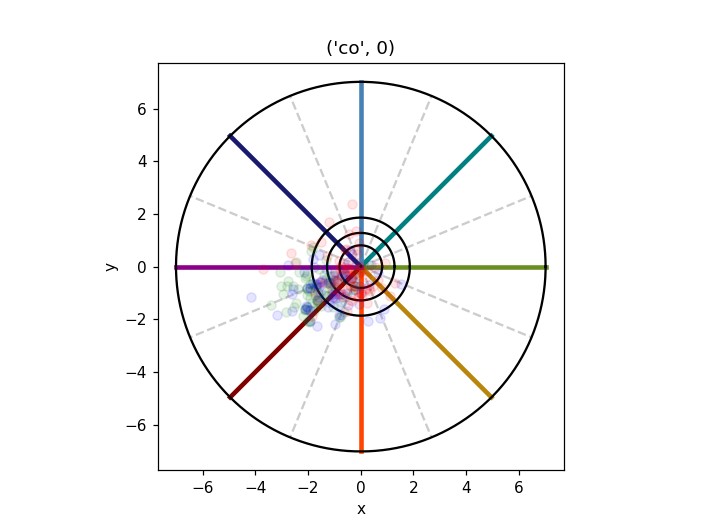

c:\anaconda3\envs\py2\lib\site-packages\matplotlib\pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


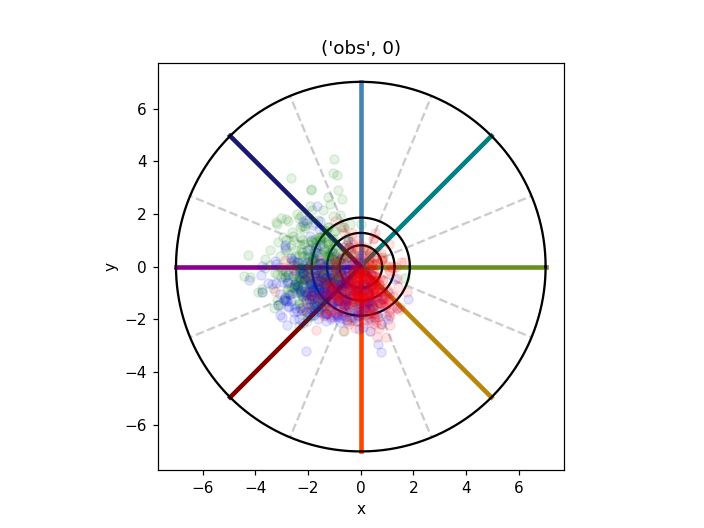

<IPython.core.display.Javascript object>


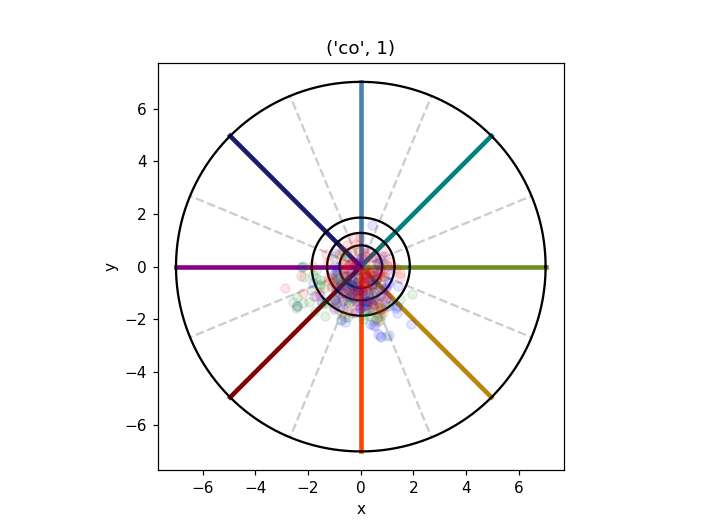

<IPython.core.display.Javascript object>


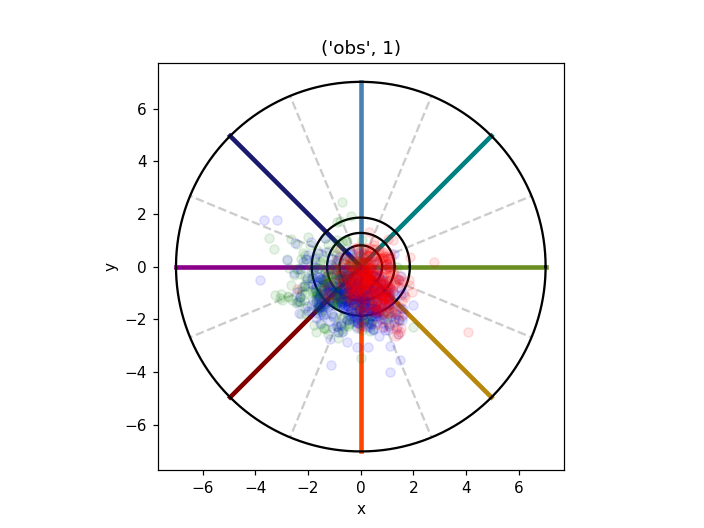

<IPython.core.display.Javascript object>


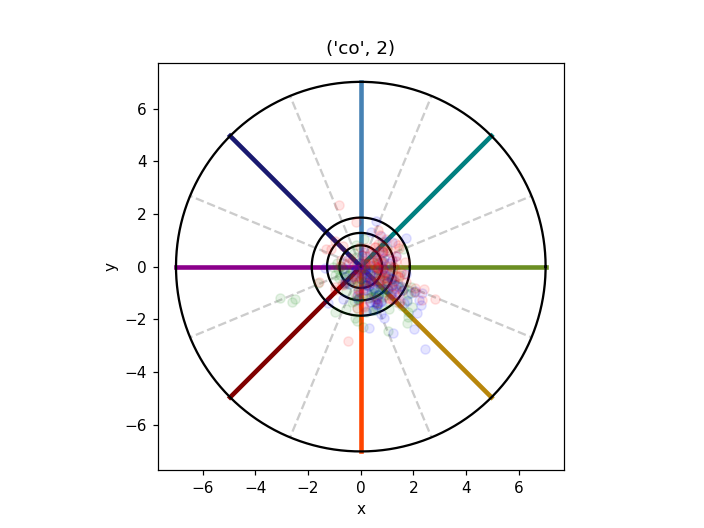

<IPython.core.display.Javascript object>


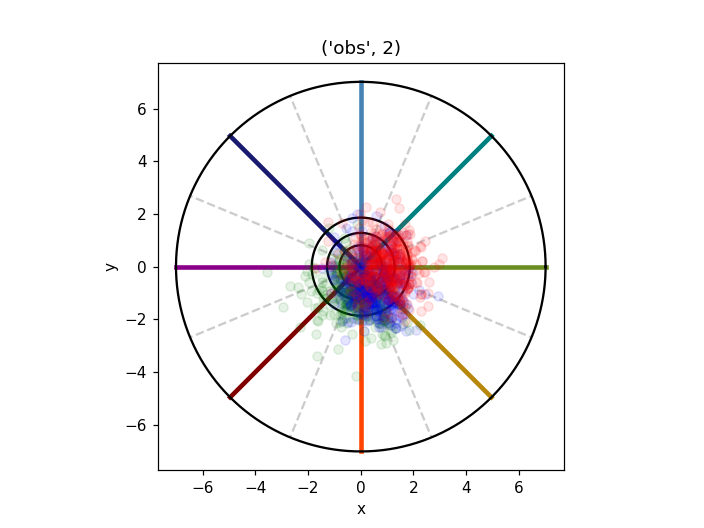

<IPython.core.display.Javascript object>


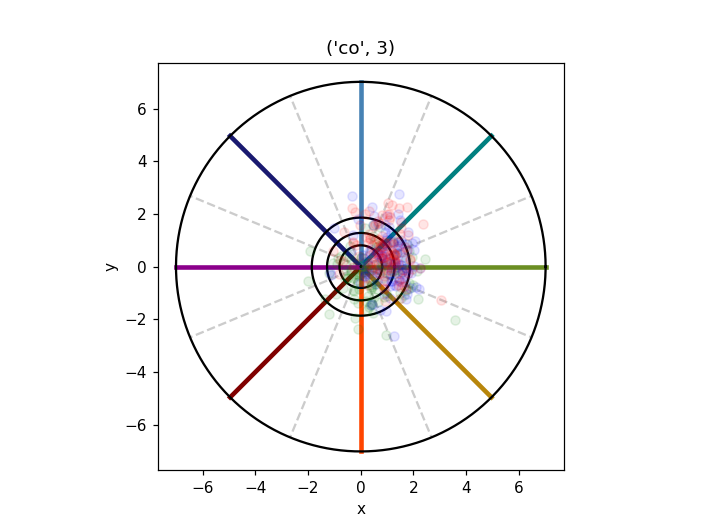

<IPython.core.display.Javascript object>


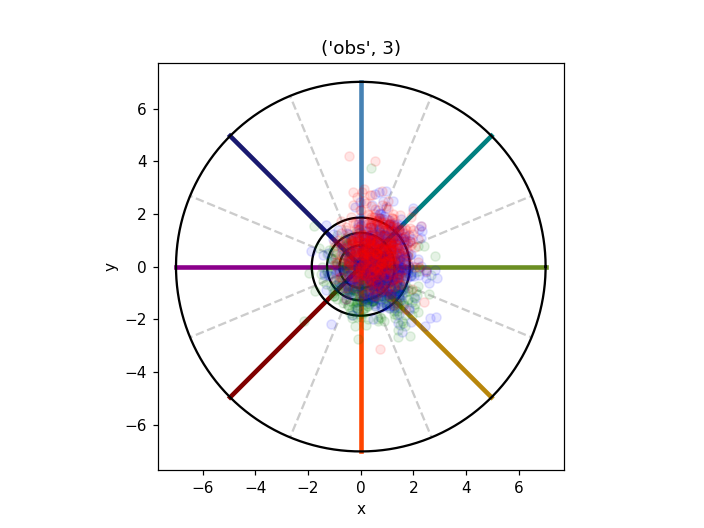

<IPython.core.display.Javascript object>


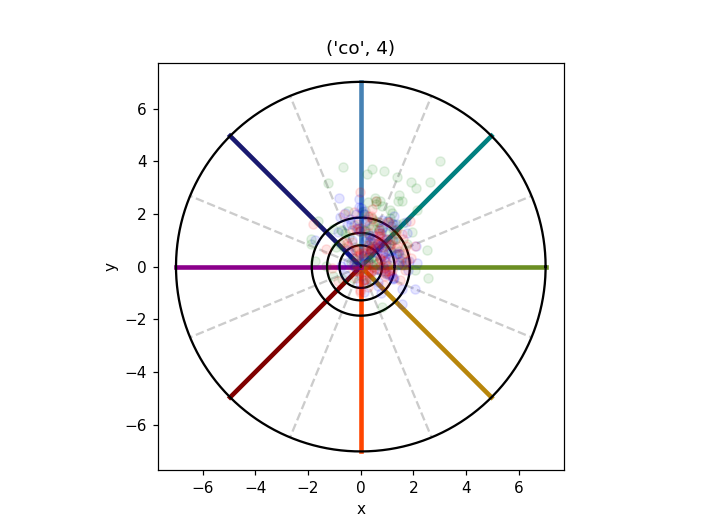

<IPython.core.display.Javascript object>


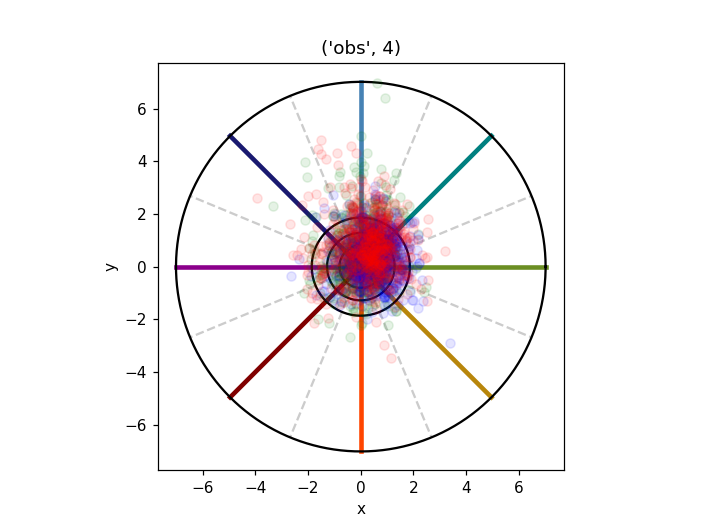

<IPython.core.display.Javascript object>


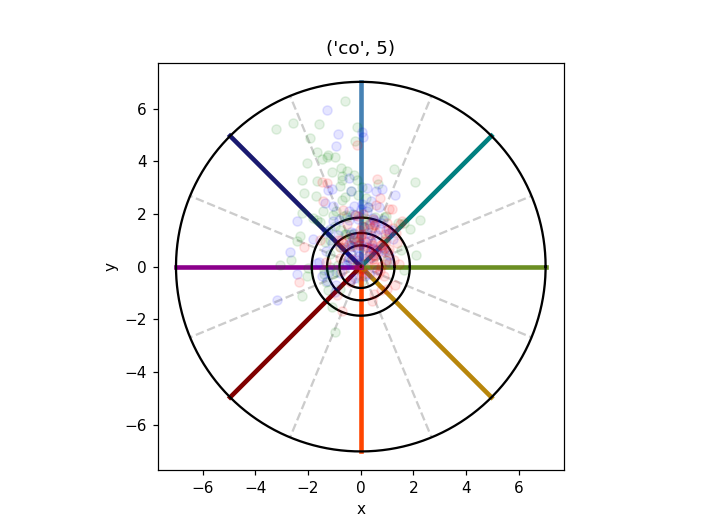

<IPython.core.display.Javascript object>


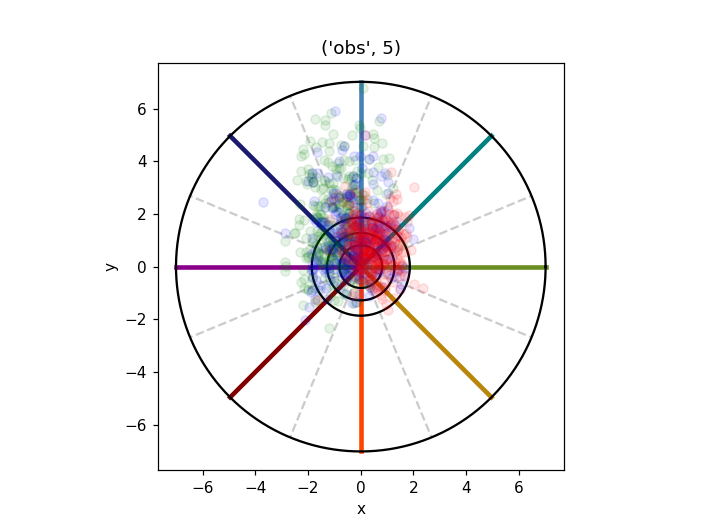

<IPython.core.display.Javascript object>


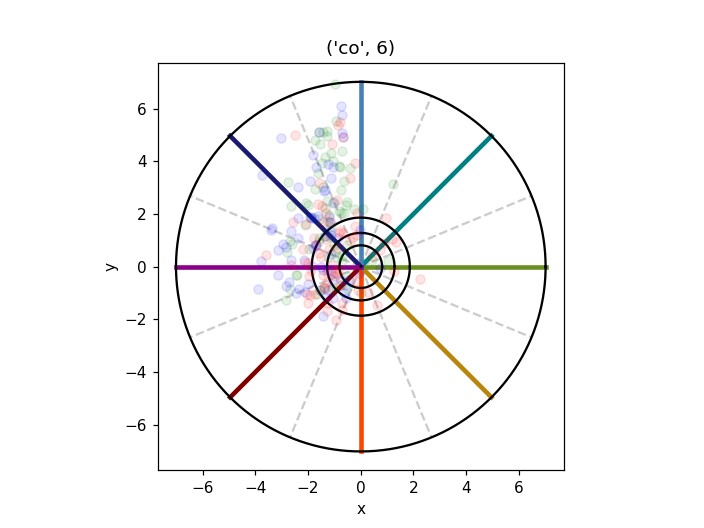

<IPython.core.display.Javascript object>


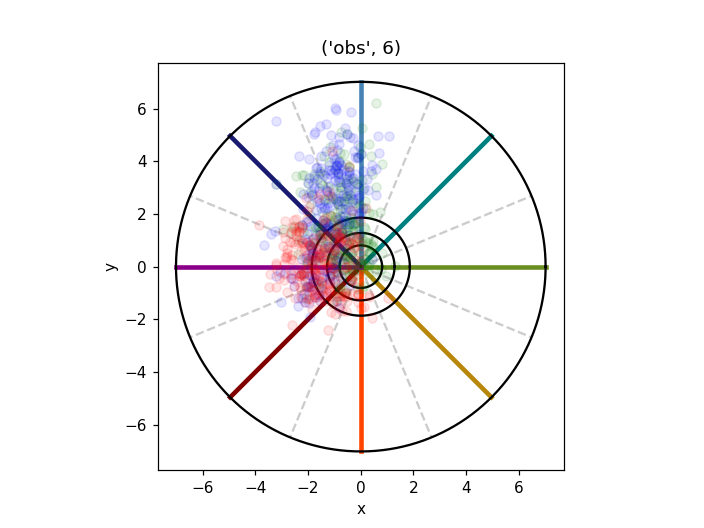

<IPython.core.display.Javascript object>


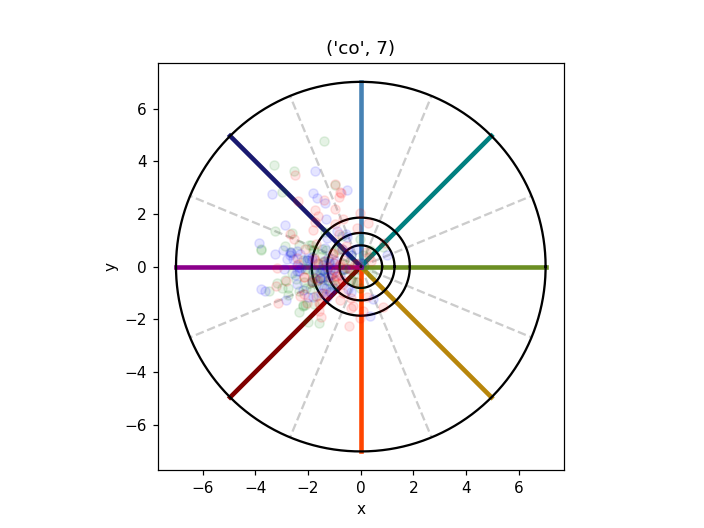

<IPython.core.display.Javascript object>


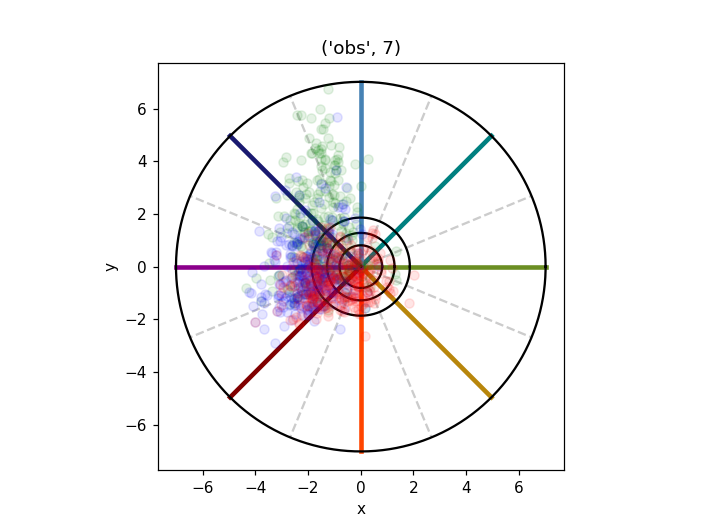

Text(0,0.5,'y')

In [10]:
#early middle late scatter plot
num_phases = 3
phases = np.linspace(0,1,num_phases+1)
trial_phase = np.array([phases[0:-1],phases[1:]])

phase_color = ['g', 'b', 'r'] #maroon
for target in range(num_targets): #[0]
#     plt.subplot(2,3,)
    for task in range(num_tasks):
        plt.figure()
        plot_command_bin()   
        plt.title((task_list[task], target))    
        for phase in range(num_phases):
#             plt.title((task_list[task], target, 'phase: ', phase))    
                 
            task_sel = (df['task'] == task)
            target_sel = (df['target'] == target)
            phase_sel = (df['prog'] >= trial_phase[0,phase]) & (df['prog'] <= trial_phase[1,phase])
            sel = task_sel & target_sel & phase_sel

            x = df['u_vx'][sel]
            y = df['u_vy'][sel]
            plt.scatter(x, y,alpha=0.1,color=phase_color[phase])
# phase_color[phase])#target_color[target])
plt.axis('square')
plt.xlabel('x')
plt.ylabel('y')

### Check the mean differences

In [11]:
#NOTE: This takes some time...
n_list = ['n_'+str(i) for i in np.arange(num_neurons)]

min_trials = 5
win = [-5,5] 
num_win = win[1]-win[0]+1
num_var = len(list(df.columns))
psth_var = ['u_vx', 'u_vy', 'kin_px', 'kin_py']
psth_var.extend(n_list)
print(psth_var)
task_pairs = [(0,0), (0,1), (1,1)]
if win[0] <= 0:
    zero_lag_idx = -win[0]

#GET TRIALS:    
task_target_bin_dic=bmi_b.calc_command_trials_dic_da(df, win, num_var, num_tasks, num_targets, num_mag_bins, num_angle_bins)

#GET PSTH:
bmi_b.calc_command_psth(task_target_bin_dic, psth_var, min_trials, num_tasks, num_targets, num_mag_bins, num_angle_bins)

['u_vx', 'u_vy', 'kin_px', 'kin_py', 'n_0', 'n_1', 'n_2', 'n_3', 'n_4', 'n_5', 'n_6', 'n_7', 'n_8', 'n_9', 'n_10', 'n_11', 'n_12', 'n_13', 'n_14', 'n_15', 'n_16', 'n_17', 'n_18', 'n_19', 'n_20', 'n_21', 'n_22', 'n_23', 'n_24', 'n_25', 'n_26', 'n_27', 'n_28', 'n_29', 'n_30', 'n_31', 'n_32', 'n_33', 'n_34', 'n_35', 'n_36', 'n_37', 'n_38', 'n_39', 'n_40', 'n_41', 'n_42', 'n_43']
(0, 0, 0, 0, 8)
(0, 0, 0, 1, 3)
(0, 0, 0, 2, 2)
(0, 0, 0, 3, 3)
(0, 0, 0, 4, 0)
(0, 0, 0, 5, 1)
(0, 0, 0, 6, 2)
(0, 0, 0, 7, 5)
(0, 0, 1, 0, 10)
(0, 0, 1, 1, 7)
(0, 0, 1, 2, 2)
(0, 0, 1, 3, 1)
(0, 0, 1, 4, 0)
(0, 0, 1, 5, 1)
(0, 0, 1, 6, 2)
(0, 0, 1, 7, 3)
(0, 0, 2, 0, 19)
(0, 0, 2, 1, 5)
(0, 0, 2, 2, 2)
(0, 0, 2, 3, 0)
(0, 0, 2, 4, 0)
(0, 0, 2, 5, 2)
(0, 0, 2, 6, 0)
(0, 0, 2, 7, 11)
(0, 0, 3, 0, 29)
(0, 0, 3, 1, 3)
(0, 0, 3, 2, 0)
(0, 0, 3, 3, 0)
(0, 0, 3, 4, 0)
(0, 0, 3, 5, 1)
(0, 0, 3, 6, 1)
(0, 0, 3, 7, 17)
(0, 1, 0, 0, 14)
(0, 1, 0, 1, 14)
(0, 1, 0, 2, 19)
(0, 1, 0, 3, 8)
(0, 1, 0, 4, 4)
(0, 1, 0, 5, 8)
(0, 1

(1, 6, 3, 5, 146)
(1, 6, 3, 6, 90)
(1, 6, 3, 7, 60)
(1, 7, 0, 0, 11)
(1, 7, 0, 1, 8)
(1, 7, 0, 2, 3)
(1, 7, 0, 3, 2)
(1, 7, 0, 4, 2)
(1, 7, 0, 5, 3)
(1, 7, 0, 6, 4)
(1, 7, 0, 7, 3)
(1, 7, 1, 0, 19)
(1, 7, 1, 1, 5)
(1, 7, 1, 2, 2)
(1, 7, 1, 3, 0)
(1, 7, 1, 4, 0)
(1, 7, 1, 5, 3)
(1, 7, 1, 6, 8)
(1, 7, 1, 7, 22)
(1, 7, 2, 0, 34)
(1, 7, 2, 1, 9)
(1, 7, 2, 2, 0)
(1, 7, 2, 3, 0)
(1, 7, 2, 4, 1)
(1, 7, 2, 5, 4)
(1, 7, 2, 6, 17)
(1, 7, 2, 7, 55)
(1, 7, 3, 0, 96)
(1, 7, 3, 1, 1)
(1, 7, 3, 2, 0)
(1, 7, 3, 3, 1)
(1, 7, 3, 4, 0)
(1, 7, 3, 5, 40)
(1, 7, 3, 6, 72)
(1, 7, 3, 7, 139)


### compute if the behavior diffs at lag 0 are significant

In [13]:
task_target_bin_dic[0,0,0,0]

<xarray.DataArray (var: 81, time: 11, trial: 8)>
array([[[1., 0., ..., 0., 2.],
        [3., 1., ..., 1., 3.],
        ...,
        [0., 0., ..., 2., 0.],
        [1., 1., ..., 1., 2.]],

       [[3., 0., ..., 0., 0.],
        [1., 0., ..., 0., 1.],
        ...,
        [1., 1., ..., 0., 0.],
        [1., 1., ..., 0., 1.]],

       ...,

       [[0., 3., ..., 1., 2.],
        [3., 3., ..., 0., 2.],
        ...,
        [0., 3., ..., 1., 0.],
        [2., 3., ..., 1., 0.]],

       [[1., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.],
        ...,
        [6., 0., ..., 0., 7.],
        [0., 0., ..., 0., 7.]]])
Coordinates:
  * var      (var) |S13 'n_0' 'n_1' 'n_2' ... 'u_v_mag_bin' 'u_v_angle_bin'
  * trial    (trial) int32 0 1 2 3 4 5 6 7
  * time     (time) int32 -5 -4 -3 -2 -1 0 1 2 3 4 5

In [12]:
task_target_bin_dic[0,0,0,0,'psth']

<xarray.DataArray (var: 48, time: 11)>
array([[-1.269932, -1.241932, -1.649923, ..., -0.971476, -0.553832, -0.682746],
       [-0.724789, -1.09507 , -1.053345, ..., -0.806701, -0.528424, -0.807107],
       [-3.235165, -3.528743, -3.844156, ..., -5.098894, -5.24857 , -5.381551],
       ...,
       [ 4.625   ,  4.125   ,  6.75    , ...,  5.25    ,  4.625   ,  5.25    ],
       [ 0.875   ,  1.      ,  1.625   , ...,  1.75    ,  2.875   ,  1.875   ],
       [ 0.75    ,  2.      ,  0.75    , ...,  0.625   ,  0.875   ,  0.625   ]])
Coordinates:
  * var      (var) |S13 'u_vx' 'u_vy' 'kin_px' 'kin_py' ... 'n_41' 'n_42' 'n_43'
  * time     (time) int32 -5 -4 -3 -2 -1 0 1 2 3 4 5

In [86]:
#Compare behavior within bin, for an example
bm = 3
ba = 5
task0 = 1
t0 = 7
task1 = 1
t1 = 3
# task0 = 0
# t0 = 5
# task1 = 1
# t1 = 5

d0 = task_target_bin_dic[task0,t0,bm,ba].loc[['u_vx', 'u_vy'],0,:]
d1 = task_target_bin_dic[task1,t1,bm,ba].loc[['u_vx', 'u_vy'],0,:]
# task_target_bin_dic[task1,t1,bm,ba]

#Run t-test: 
x0 = np.array(d0.loc['u_vx', :])
x1 = np.array(d1.loc['u_vx', :])
(tstat,pval) = scipy.stats.ttest_ind(x0, x1, equal_var=True)
print(pval)

y0 = np.array(d0.loc['u_vy', :])
y1 = np.array(d1.loc['u_vy', :])
(tstat,pval) = scipy.stats.ttest_ind(y0, y1, equal_var=True)
print(pval)

5.245075764012386e-20
5.7727218420101314e-09


In [104]:
match_var = ['u_vx', 'u_vy']

d0 = task_target_bin_dic[task0,t0,bm,ba].loc[['u_vx', 'u_vy'],0,:]
d1 = task_target_bin_dic[task1,t1,bm,ba].loc[['u_vx', 'u_vy'],0,:]
d_list = [d0, d1]

pval_sig = 0.05

kept_list, discard_list, df_r, ttest_r, mean_r = bmi_b.subsample_2datasets_to_match_mean(match_var, d_list, pval_sig)

('num iterations:', 1)
('discard_list', [[18, 8], []])
Max Iter Reached
('num iterations:', 2)
('discard_list', [[18, 8, 1, 4], []])


In [93]:
sio_stat.ttest_ind

<function scipy.stats.stats.ttest_ind>

In [ ]:
#The main code calculating differences across bins

In [53]:
columns = ['n_diff_norm', 'b_diff_norm', 'b_diff_norm_lag0',
            'mag_bin', 'angle_bin', 
            'task0', 'target0', 'num_trials0', 'u_vx0', 'u_vy0',
            'task1', 'target1', 'num_trials1', 'u_vx1', 'u_vy1',
            'u_vx_diff_p', 'u_vx_diff_tstat',
            'u_vy_diff_p', 'u_vy_diff_tstat']

num_col = len(columns)
nan_df = pd.DataFrame(np.ones((1,num_col))*np.nan, columns=columns)
df_list = []
task_pairs = [(0,0), (0,1), (1,1)]
vec_diff_dic = {}

for task0, task1 in task_pairs:
    for t0 in range(num_targets):
        if task0 == task1:
            t1_set = range(t0, num_targets)
        else:
            t1_set = range(0,num_targets)
        for t1 in t1_set:
            print(task0, t0, task1, t1)
            for bm in range(num_mag_bins):
                for ba in range(num_angle_bins):
                    num_trials0 = task_target_bin_dic[task0,t0,bm,ba,'num']
                    d0_valid = num_trials0 >= min_trials
                    num_trials1 = task_target_bin_dic[task1,t1,bm,ba,'num']
                    d1_valid = num_trials1 >= min_trials                        
                    if d0_valid&d1_valid:
                        #Check if same movement: 
                        if (task0==task1)&(t0==t1):
                            #if same movement, compare psth's on different splits of data: 
                            d0 = task_target_bin_dic[task0,t0,bm,ba,'psth',0]
                            d1 = task_target_bin_dic[task0,t0,bm,ba,'psth',1]
                            
                            sel0 = task_target_bin_dic[task0,t0,bm,ba,'psth_trials', 0]
                            dd0 = task_target_bin_dic[task0,t0,bm,ba].loc[:,0,sel0]
                            sel1 = task_target_bin_dic[task0,t0,bm,ba,'psth_trials', 1]
                            dd1 = task_target_bin_dic[task1,t1,bm,ba].loc[:,0,sel1]
                        else:
                            d0 = task_target_bin_dic[task0,t0,bm,ba,'psth']
                            d1 = task_target_bin_dic[task1,t1,bm,ba,'psth']
                                                    
                            dd0 = task_target_bin_dic[task0,t0,bm,ba].loc[:,0,:]
                            dd1 = task_target_bin_dic[task1,t1,bm,ba].loc[:,0,:]                          
                            
                        #ASSIGN:
                        vec_diff_dic[bm, ba, task0, t0, task1, t1] = d0-d1
                        df_i = copy.copy(nan_df)                        
                        
                        #neural diff is over lag 0: 
                        df_i['n_diff_norm'] = np.linalg.norm(d0.loc[n_list,0]-d1.loc[n_list,0])
                        
                        #behavior diff is over all lags: 
                        df_i['b_diff_norm'] = np.linalg.norm(d0.loc[['u_vx', 'u_vy'],:]-d1.loc[['u_vx', 'u_vy'],:])
                        
                        #behavior diff is over all lags: 
                        df_i['b_diff_norm_lag0'] = np.linalg.norm(d0.loc[['u_vx', 'u_vy'],0]-d1.loc[['u_vx', 'u_vy'],0])                        
                        
                        df_i['mag_bin'] = bm
                        df_i['angle_bin'] = ba                 
                        
                        df_i['task0'] = task0
                        df_i['target0'] = t0
                        df_i['num_trials0'] = num_trials0
                        df_i['u_vx0'] = float(d0.loc['u_vx',0])
                        df_i['u_vy0'] = float(d0.loc['u_vy',0])

                        df_i['task1'] = task1
                        df_i['target1'] = t1
                        df_i['num_trials1'] = num_trials1
                        df_i['u_vx1'] = float(d1.loc['u_vx',0])
                        df_i['u_vy1'] = float(d1.loc['u_vy',0])
                        
                        #Check if behavior is significantly different within bin: 
                        #X:
                        x0 = np.array(dd0.loc['u_vx', :])
                        x1 = np.array(dd1.loc['u_vx', :])
#                         print(x0.shape, x1.shape)
                        (tstat,pval) = scipy.stats.ttest_ind(x0, x1, equal_var=True)
                        df_i['u_vx_diff_p'] = pval
                        df_i['u_vx_diff_tstat'] = tstat
                        #Y:
                        y0 = np.array(dd0.loc['u_vy', :])
                        y1 = np.array(dd1.loc['u_vy', :])
                        (tstat,pval) = scipy.stats.ttest_ind(y0, y1, equal_var=True)
                        df_i['u_vy_diff_p'] = pval
                        df_i['u_vy_diff_tstat'] = tstat                          
                        
                        #APPEND:
                        df_list.append(df_i)

diff_df = pd.concat(df_list, ignore_index=True)

(0, 0, 0, 0)
(0, 0, 0, 1)
(0, 0, 0, 2)
(0, 0, 0, 3)
(0, 0, 0, 4)
(0, 0, 0, 5)
(0, 0, 0, 6)
(0, 0, 0, 7)
(0, 1, 0, 1)
(0, 1, 0, 2)
(0, 1, 0, 3)
(0, 1, 0, 4)
(0, 1, 0, 5)
(0, 1, 0, 6)
(0, 1, 0, 7)
(0, 2, 0, 2)
(0, 2, 0, 3)
(0, 2, 0, 4)
(0, 2, 0, 5)
(0, 2, 0, 6)
(0, 2, 0, 7)
(0, 3, 0, 3)
(0, 3, 0, 4)
(0, 3, 0, 5)
(0, 3, 0, 6)
(0, 3, 0, 7)
(0, 4, 0, 4)
(0, 4, 0, 5)
(0, 4, 0, 6)
(0, 4, 0, 7)
(0, 5, 0, 5)
(0, 5, 0, 6)
(0, 5, 0, 7)
(0, 6, 0, 6)
(0, 6, 0, 7)
(0, 7, 0, 7)
(0, 0, 1, 0)
(0, 0, 1, 1)
(0, 0, 1, 2)
(0, 0, 1, 3)
(0, 0, 1, 4)
(0, 0, 1, 5)
(0, 0, 1, 6)
(0, 0, 1, 7)
(0, 1, 1, 0)
(0, 1, 1, 1)
(0, 1, 1, 2)
(0, 1, 1, 3)
(0, 1, 1, 4)
(0, 1, 1, 5)
(0, 1, 1, 6)
(0, 1, 1, 7)
(0, 2, 1, 0)
(0, 2, 1, 1)
(0, 2, 1, 2)
(0, 2, 1, 3)
(0, 2, 1, 4)
(0, 2, 1, 5)
(0, 2, 1, 6)
(0, 2, 1, 7)
(0, 3, 1, 0)
(0, 3, 1, 1)
(0, 3, 1, 2)
(0, 3, 1, 3)
(0, 3, 1, 4)
(0, 3, 1, 5)
(0, 3, 1, 6)
(0, 3, 1, 7)
(0, 4, 1, 0)
(0, 4, 1, 1)
(0, 4, 1, 2)
(0, 4, 1, 3)
(0, 4, 1, 4)
(0, 4, 1, 5)
(0, 4, 1, 6)
(0, 4, 1, 7)
(0, 5, 1, 0)

In [58]:
#Now calculate the fraction of comparisons that have sig different means.  
#Split by mag_bin, and different movement selections: 

#accumulate the differences: 
min_trials_analyze = 15

#sel: 
num_trials0_sel = (diff_df['num_trials0']>=min_trials_analyze) #5
num_trials1_sel = (diff_df['num_trials1']>=min_trials_analyze) #5

sel_universal = \
    num_trials0_sel\
    &num_trials1_sel\

sel_dic = {}
move_list = ['within_move', 'within_task', 'within_co', 'within_obs', 'across_task', 'across_move']
sel_dic['within_move'] = (diff_df['target0']==diff_df['target1'])&(diff_df['task0']==diff_df['task1'])
sel_dic['within_task'] = (diff_df['target0']!=diff_df['target1'])&(diff_df['task0']==diff_df['task1'])
sel_dic['within_co'] = (diff_df['target0']!=diff_df['target1'])&(diff_df['task0']==diff_df['task1'])&(diff_df['task0']==0)
sel_dic['within_obs'] = (diff_df['target0']!=diff_df['target1'])&(diff_df['task0']==diff_df['task1'])&(diff_df['task0']==1)
sel_dic['across_task'] = (diff_df['task0']!=diff_df['task1'])
sel_dic['across_move'] = (diff_df['task0']!=diff_df['task1'])|(diff_df['target0']!=diff_df['target1'])

mag_list = [0,1,2,3]
for bm in mag_list:
    sel_dic['mag', bm] = (diff_df['mag_bin']==bm)

diff_dic = {}
for bm in mag_list:
    for move in move_list: 
        sel = sel_universal\
        &sel_dic[move]\
        &sel_dic['mag', bm]
        diff_dic[move,bm,'u_vx'] = diff_df.loc[sel,'u_vx_diff_p']
        diff_dic[move,bm,'u_vy'] = diff_df.loc[sel,'u_vy_diff_p']
    
    

In [72]:
move='across_task'
bm = 3
var_list = ['u_vx', 'u_vy']
for bm in mag_list:
    for var in var_list:
        print('mag:', bm, 'var:', var)
        num_sig = len(np.where(diff_dic[move,bm,var]<=0.05)[0])
        num_total = len(diff_dic[move,bm,var])
        frac_diff = float(num_sig)/num_total
        print('frac pairs sig different:', frac_diff)


('mag:', 0, 'var:', 'u_vx')
('frac pairs sig different:', 0.0)
('mag:', 0, 'var:', 'u_vy')
('frac pairs sig different:', 0.0)
('mag:', 1, 'var:', 'u_vx')
('frac pairs sig different:', 0.046511627906976744)
('mag:', 1, 'var:', 'u_vy')
('frac pairs sig different:', 0.06976744186046512)
('mag:', 2, 'var:', 'u_vx')
('frac pairs sig different:', 0.21739130434782608)
('mag:', 2, 'var:', 'u_vy')
('frac pairs sig different:', 0.15217391304347827)
('mag:', 3, 'var:', 'u_vx')
('frac pairs sig different:', 0.3333333333333333)
('mag:', 3, 'var:', 'u_vy')
('frac pairs sig different:', 0.37037037037037035)


In [54]:
diff_df.head()

n_diff_norm  b_diff_norm  b_diff_norm_lag0  mag_bin  angle_bin  task0  \
0     4.220486     2.198242          0.246630        0          0      0   
1     6.198118     2.894816          0.134021        0          7      0   
2     4.967897     2.719560          0.126134        1          0      0   
3     4.654001     3.343104          0.046285        1          1      0   
4     2.154811     2.457364          0.126133        2          0      0   

   target0  num_trials0     u_vx0     u_vy0  task1  target1  num_trials1  \
0        0            8 -0.258968 -0.419847      0        0            8   
1        0            5 -0.553175 -0.008813      0        0            5   
2        0           10 -0.755986 -0.643299      0        0           10   
3        0            7 -0.033967 -0.932866      0        0            7   
4        0           19 -1.008399 -1.044301      0        0           19   

      u_vx1     u_vy1  u_vx_diff_p  u_vx_diff_tstat  u_vy_diff_p  \
0 -0.475183 -0.301200     0.178863         1.521879     0.277005   
1 -0.673429 -0.067980     0.255535         1.401758     0.755360   
2 -0.870251 -0.696718     0.377590         0.934090     0.738731   
3  0.011959 -0.938623     0.812322        -0.250290     0.952672   
4 -1.127838 -1.003754     0.307841         1.051290     0.739512   

   u_vy_diff_tstat  
0        -1.195470  
1         0.341336  
2         0.345357  
3         0.062386  
4        -0.337985

<IPython.core.display.Javascript object>


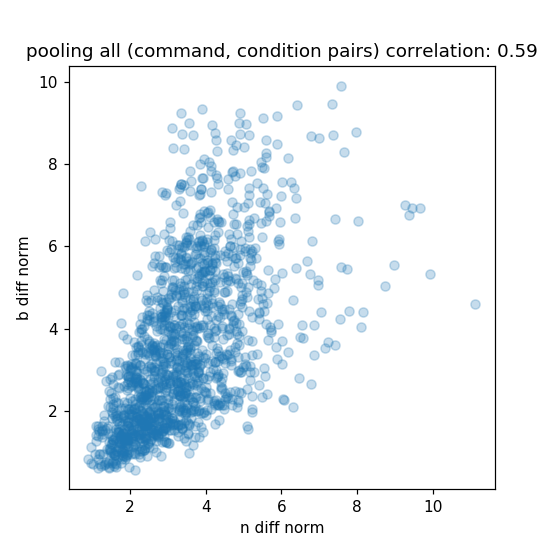

Text(0.5,1,'pooling all (command, condition pairs) correlation: 0.59')

In [44]:
#Pool all differences: 
plt.figure(figsize=(5,5))
x = diff_df.loc[:,'n_diff_norm']
y = diff_df.loc[:,'b_diff_norm']
plt.scatter(x,y,alpha=0.25)
plt.xlabel('n diff norm')
plt.ylabel('b diff norm')
r,p = scipy.stats.pearsonr(x,y)
plt.title('pooling all (command, condition pairs) correlation: ' + str(round(r,2)))


<IPython.core.display.Javascript object>


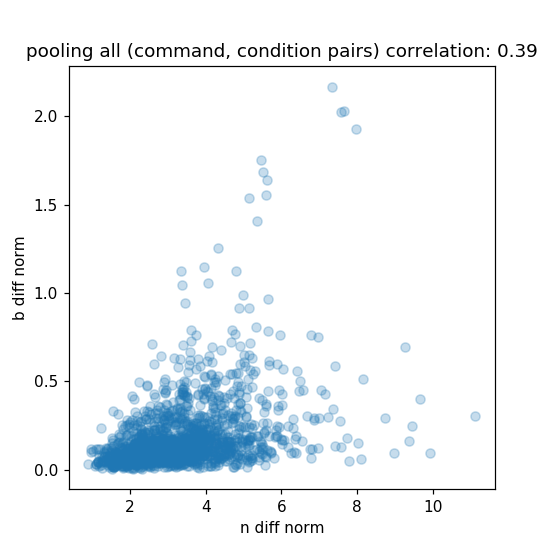

Text(0.5,1,'pooling all (command, condition pairs) correlation: 0.39')

In [45]:
#Check lag0:
plt.figure(figsize=(5,5))
x = diff_df.loc[:,'n_diff_norm']
y = diff_df.loc[:,'b_diff_norm_lag0']
plt.scatter(x,y,alpha=0.25)
plt.xlabel('n diff norm')
plt.ylabel('b diff norm')
r,p = scipy.stats.pearsonr(x,y)
plt.title('pooling all (command, condition pairs) correlation: ' + str(round(r,2)))


In [ ]:
#TODO: compare: within move, within co, within obs, across task, across move: 
#Check: if the segment is just one lag behind and ahead vs 5 lags behind and ahead like I have now... 

In [46]:
#accumulate the differences: 
min_trials_analyze = 15
max_mag=3

#sel: 
num_trials0_sel = (diff_df['num_trials0']>=min_trials_analyze) #5
num_trials1_sel = (diff_df['num_trials1']>=min_trials_analyze) #5
mag_sel = (diff_df['mag_bin']<=max_mag)

sel_universal = \
    num_trials0_sel\
    &num_trials1_sel\
    &mag_sel

move_sel_dic = {}
move_list = ['within_move', 'within_task', 'within_co', 'within_obs', 'across_task', 'across_move']
move_sel_dic['within_move', 'sel'] = (diff_df['target0']==diff_df['target1'])&(diff_df['task0']==diff_df['task1'])
move_sel_dic['within_task', 'sel'] = (diff_df['target0']!=diff_df['target1'])&(diff_df['task0']==diff_df['task1'])
move_sel_dic['within_co', 'sel'] = (diff_df['target0']!=diff_df['target1'])&(diff_df['task0']==diff_df['task1'])&(diff_df['task0']==0)
move_sel_dic['within_obs', 'sel'] = (diff_df['target0']!=diff_df['target1'])&(diff_df['task0']==diff_df['task1'])&(diff_df['task0']==1)
move_sel_dic['across_task', 'sel'] = (diff_df['task0']!=diff_df['task1'])
move_sel_dic['across_move', 'sel'] = (diff_df['task0']!=diff_df['task1'])|(diff_df['target0']!=diff_df['target1'])

for move in move_list: 
    sel = sel_universal\
    &move_sel_dic[move,'sel']
    move_sel_dic[move, 'n_diff'] = diff_df.loc[sel,'n_diff_norm']
    move_sel_dic[move, 'b_diff'] = diff_df.loc[sel,'b_diff_norm']
    move_sel_dic[move, 'b_diff_lag0'] = diff_df.loc[sel,'b_diff_norm_lag0']
    
    

<IPython.core.display.Javascript object>


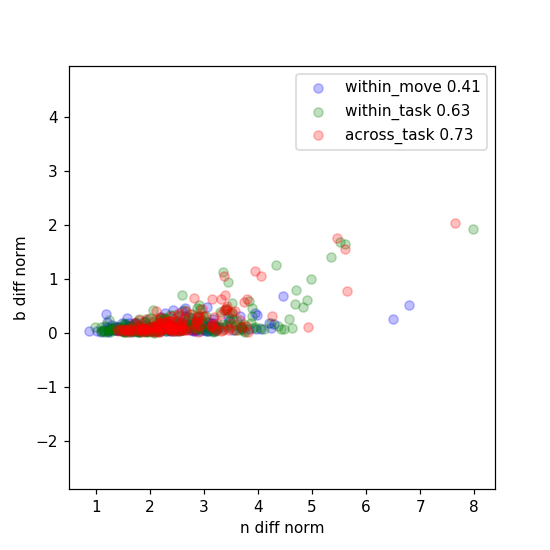

In [60]:
# move = 'within_move'
move_plot = ['within_move', 'within_task', 'across_task']
move_plot_color = ['b', 'g', 'r']
plt.figure(figsize=(5,5))
r_list = []
for i,move in enumerate(move_plot):
    x = move_sel_dic[move, 'n_diff']
    y = move_sel_dic[move, 'b_diff_lag0']
    r,p = scipy.stats.pearsonr(x,y)
    r_list.append(r)
    plt.scatter(x,y,color=move_plot_color[i],alpha=0.25,label=move + ' ' + str(round(r,2)))
    plt.axis('equal')
    plt.xlabel('n diff norm')
    plt.ylabel('b diff norm')
plt.legend()

# title_str = ''
# for i,move in enumerate(move_plot):
#     title_str += move + ' corr:' + str(round(r_list[i],2))
# plt.title(title_str)

<IPython.core.display.Javascript object>


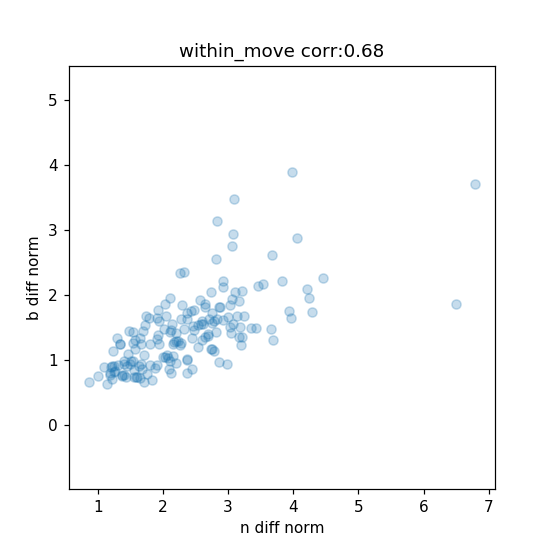

<IPython.core.display.Javascript object>


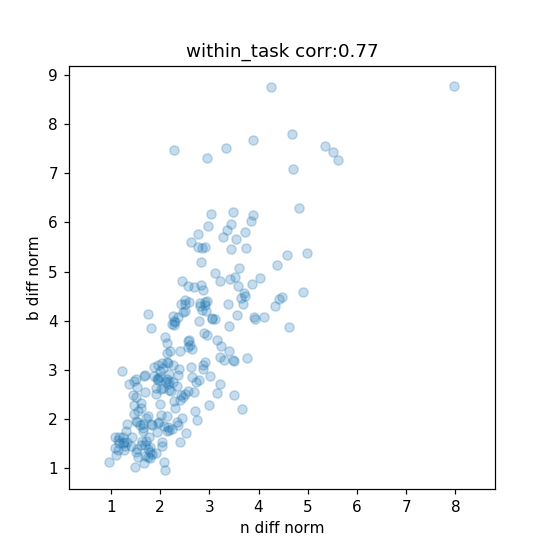

<IPython.core.display.Javascript object>


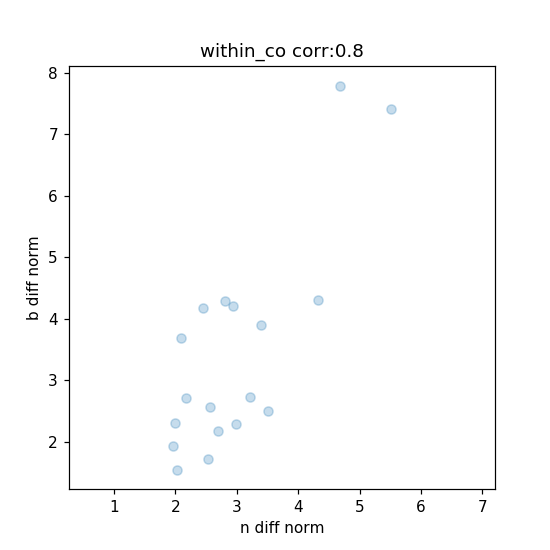

<IPython.core.display.Javascript object>


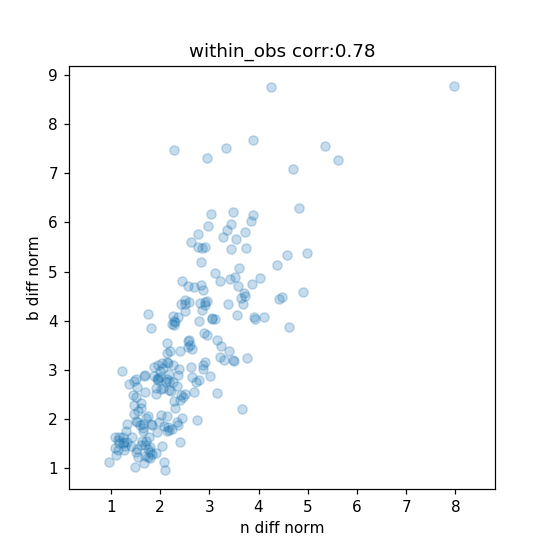

<IPython.core.display.Javascript object>


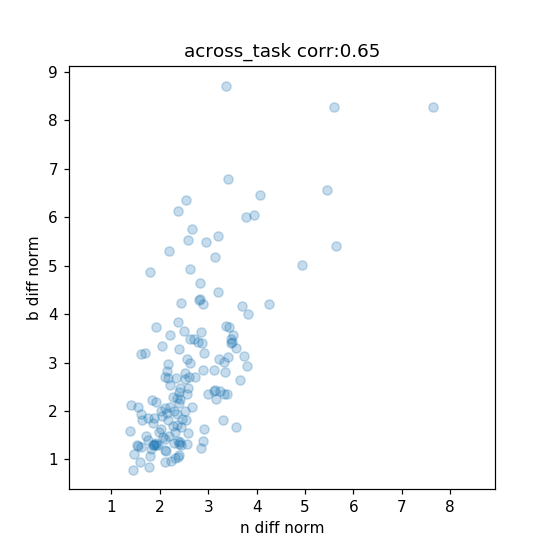

<IPython.core.display.Javascript object>


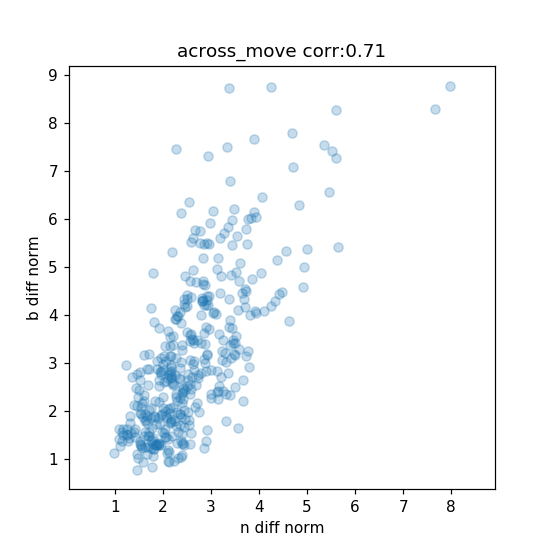

In [47]:
# move = 'within_move'
for move in move_list:
    x = move_sel_dic[move, 'n_diff']
    y = move_sel_dic[move, 'b_diff']
    r,p = scipy.stats.pearsonr(x,y)
    plt.figure(figsize=(5,5))
    plt.scatter(x,y,alpha=0.25)
    plt.axis('equal')
    plt.title(move + ' corr:' + str(round(r,2)))
    plt.xlabel('n diff norm')
    plt.ylabel('b diff norm')


In [ ]:
#Now choose a specific condition: 

28

<IPython.core.display.Javascript object>


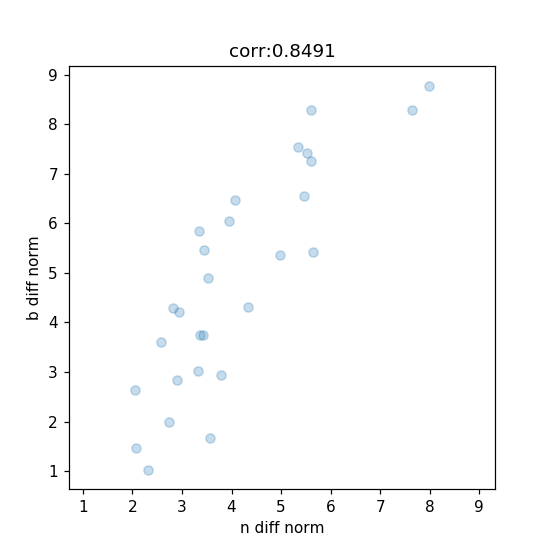

28


In [171]:
mag_bin = 3
angle_bin = 5
min_trials_analyze = 15

num_trials0_sel = (diff_df['num_trials0']>=min_trials_analyze) #5
num_trials1_sel = (diff_df['num_trials1']>=min_trials_analyze) #5
angle_sel = (diff_df['angle_bin']==angle_bin)
mag_sel = (diff_df['mag_bin']==mag_bin)
command_sel = angle_sel&mag_sel

sel_universal = \
    num_trials0_sel\
    &num_trials1_sel\
    &command_sel

sel = move_sel_dic['across_move', 'sel']&sel_universal

x = diff_df.loc[sel,'n_diff_norm']
y = diff_df.loc[sel,'b_diff_norm'] #b_diff_lag0
r,p = scipy.stats.pearsonr(x,y)

plt.figure(figsize=(5,5))
plt.scatter(x,y,alpha=0.25)
plt.axis('equal')
plt.title('corr:' + str(round(r,4)))
plt.xlabel('n diff norm')
plt.ylabel('b diff norm')

num_comparisons = len(np.where(sel)[0])
print(num_comparisons)

sel_ex = sel

In [177]:
diff_df[sel]

n_diff_norm  b_diff_norm  b_diff_norm_lag0  mag_bin  angle_bin  task0  \
181      2.931653     4.208610          0.432494        3          5      0   
182      5.514300     7.419328          1.683440        3          5      0   
198      4.329379     4.302745          1.254695        3          5      0   
607      3.563806     1.662450          0.403464        3          5      0   
619      2.062912     1.469428          0.127457        3          5      0   
631      2.811541     4.293935          0.640543        3          5      0   
634      4.060522     6.462052          1.055829        3          5      0   
636      5.600391     8.277502          1.552105        3          5      0   
670      5.640524     5.415254          0.783492        3          5      0   
682      3.426296     3.743060          0.499042        3          5      0   
696      2.323077     1.024416          0.210074        3          5      0   
704      3.794427     2.929954          0.628087        3          5      0   
711      3.940862     6.047526          1.147324        3          5      0   
728      7.651027     8.285025          2.029423        3          5      0   
732      5.458608     6.554338          1.752543        3          5      0   
738      3.363781     3.752962          1.044656        3          5      0   
743      3.319804     3.017449          0.627611        3          5      0   
749      2.895579     2.846954          0.338761        3          5      0   
1251     2.744965     1.993108          0.292486        3          5      1   
1276     4.987679     5.368042          0.991056        3          5      1   
1285     5.351292     7.547173          1.407620        3          5      1   
1296     7.976355     8.777149          1.929405        3          5      1   
1354     2.581332     3.601841          0.708801        3          5      1   
1365     3.351411     5.836509          1.126886        3          5      1   
1379     5.607249     7.265883          1.640304        3          5      1   
1418     2.056406     2.627954          0.418100        3          5      1   
1430     3.437046     5.451785          0.945342        3          5      1   
1451     3.520589     4.894112          0.554175        3          5      1   

      target0  num_trials0     u_vx0     u_vy0  task1  target1  num_trials1  \
181         4           20  0.012104  2.571975      0        5           35   
182         4           20  0.012104  2.571975      0        6           20   
198         5           35 -0.157883  2.969662      0        6           20   
607         4           20  0.012104  2.571975      1        3           35   
619         4           20  0.012104  2.571975      1        4          103   
631         4           20  0.012104  2.571975      1        5          152   
634         4           20  0.012104  2.571975      1        6          146   
636         4           20  0.012104  2.571975      1        7           40   
670         5           35 -0.157883  2.969662      1        3           35   
682         5           35 -0.157883  2.969662      1        4          103   
696         5           35 -0.157883  2.969662      1        5          152   
704         5           35 -0.157883  2.969662      1        6          146   
711         5           35 -0.157883  2.969662      1        7           40   
728         6           20 -0.820828  4.034915      1        3           35   
732         6           20 -0.820828  4.034915      1        4          103   
738         6           20 -0.820828  4.034915      1        5          152   
743         6           20 -0.820828  4.034915      1        6          146   
749         6           20 -0.820828  4.034915      1        7           40   
1251        3           35  0.374684  2.395004      1        4          103   
1276        3           35  0.374684  2.395004      1        5          152   
1285        3           35  0.374684  2.395004      1  

<IPython.core.display.Javascript object>


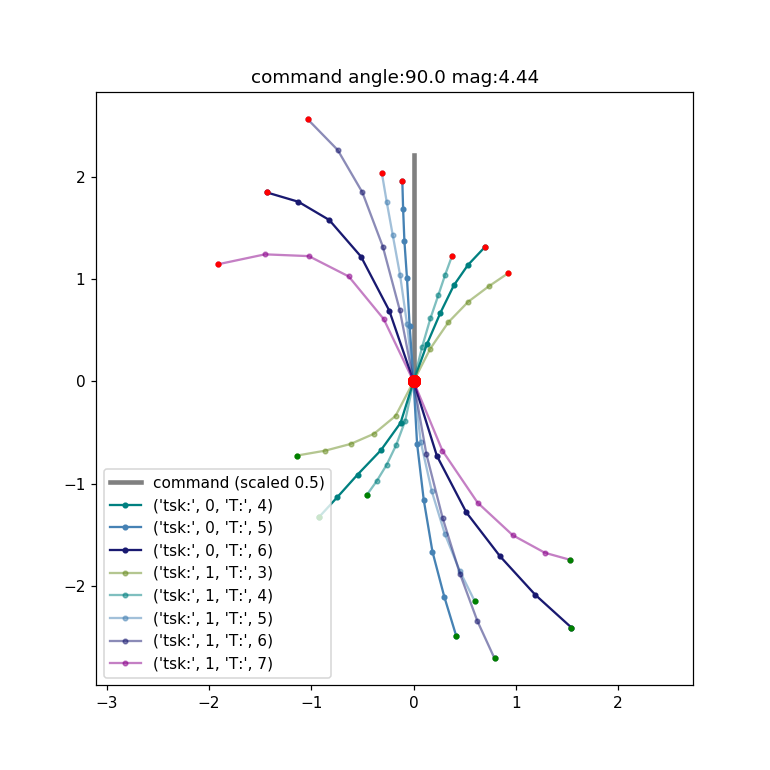

(0, 4, 20)
(0, 5, 35)
(0, 6, 20)
(1, 3, 35)
(1, 4, 103)
(1, 5, 152)
(1, 6, 146)
(1, 7, 40)


In [146]:
#Plot the trajectories compared: 
min_trials_plot = 15 #10
mag_bin_plot = 3
angle_bin = 5
sc = 0.5

#PLOT COMMAND: 

for mag_bin in [mag_bin_plot]:
    pm = mag_bin_c[mag_bin]
    pa = angle_bin_c[angle_bin]
    x_bin = pm*np.cos(pa)*sc
    y_bin = pm*np.sin(pa)*sc
    
    #-----------------------------------------------------------------------------------------------------------------
    plt.figure(figsize=(7,7))
    ax = plt.gca()
    plt.plot([0, x_bin], [0, y_bin], color=np.ones(3)*0.5, linewidth=3, label='command (scaled ' + str(sc)+')')
    task_alpha = [1, 0.5]
    for task in range(0,num_tasks):
        for target in range(0,num_targets):
            num_trials = psth_c_dic[task, target, mag_bin, angle_bin, 'num']
            if num_trials >= min_trials_plot:
                print(task, target, num_trials)
                data = psth_c_dic[task, target, mag_bin, angle_bin, 'psth']
                plt.plot(data.loc['kin_px'], data.loc['kin_py'], '.-', alpha=task_alpha[task], color=target_color[target], label=('tsk:',task,'T:',target))
                plt.plot(data.loc['kin_px', 0], data.loc['kin_py', 0], '.-', color='r', markersize=15)   
                plt.plot(data.loc['kin_px', win[1]], data.loc['kin_py', win[1]], '.-', color='r') #color=np.ones(3)*0.0
                plt.plot(data.loc['kin_px', win[0]], data.loc['kin_py', win[0]], '.-', color='g')  
    plt.axis('equal')
#     ax.set_aspect('equal')
    plt.legend()
    plt.title('command angle:'+str(round(pa*180/np.pi,2)) + ' mag:' + str(round(pm,2)))
    

In [196]:
ex_df

n_diff_norm  b_diff_norm  b_diff_norm_lag0  mag_bin  angle_bin  task0  \
181      2.931653     4.208610          0.432494        3          5      0   
182      5.514300     7.419328          1.683440        3          5      0   
198      4.329379     4.302745          1.254695        3          5      0   
607      3.563806     1.662450          0.403464        3          5      0   
619      2.062912     1.469428          0.127457        3          5      0   
631      2.811541     4.293935          0.640543        3          5      0   
634      4.060522     6.462052          1.055829        3          5      0   
636      5.600391     8.277502          1.552105        3          5      0   
670      5.640524     5.415254          0.783492        3          5      0   
682      3.426296     3.743060          0.499042        3          5      0   
696      2.323077     1.024416          0.210074        3          5      0   
704      3.794427     2.929954          0.628087        3          5      0   
711      3.940862     6.047526          1.147324        3          5      0   
728      7.651027     8.285025          2.029423        3          5      0   
732      5.458608     6.554338          1.752543        3          5      0   
738      3.363781     3.752962          1.044656        3          5      0   
743      3.319804     3.017449          0.627611        3          5      0   
749      2.895579     2.846954          0.338761        3          5      0   
1251     2.744965     1.993108          0.292486        3          5      1   
1276     4.987679     5.368042          0.991056        3          5      1   
1285     5.351292     7.547173          1.407620        3          5      1   
1296     7.976355     8.777149          1.929405        3          5      1   
1354     2.581332     3.601841          0.708801        3          5      1   
1365     3.351411     5.836509          1.126886        3          5      1   
1379     5.607249     7.265883          1.640304        3          5      1   
1418     2.056406     2.627954          0.418100        3          5      1   
1430     3.437046     5.451785          0.945342        3          5      1   
1451     3.520589     4.894112          0.554175        3          5      1   

      target0  num_trials0     u_vx0     u_vy0  task1  target1  num_trials1  \
181         4           20  0.012104  2.571975      0        5           35   
182         4           20  0.012104  2.571975      0        6           20   
198         5           35 -0.157883  2.969662      0        6           20   
607         4           20  0.012104  2.571975      1        3           35   
619         4           20  0.012104  2.571975      1        4          103   
631         4           20  0.012104  2.571975      1        5          152   
634         4           20  0.012104  2.571975      1        6          146   
636         4           20  0.012104  2.571975      1        7           40   
670         5           35 -0.157883  2.969662      1        3           35   
682         5           35 -0.157883  2.969662      1        4          103   
696         5           35 -0.157883  2.969662      1        5          152   
704         5           35 -0.157883  2.969662      1        6          146   
711         5           35 -0.157883  2.969662      1        7           40   
728         6           20 -0.820828  4.034915      1        3           35   
732         6           20 -0.820828  4.034915      1        4          103   
738         6           20 -0.820828  4.034915      1        5          152   
743         6           20 -0.820828  4.034915      1        6          146   
749         6           20 -0.820828  4.034915      1        7           40   
1251        3           35  0.374684  2.395004      1        4          103   
1276        3           35  0.374684  2.395004      1        5          152   
1285        3           35  0.374684  2.395004      1  

In [203]:
cond_ex = []
for i in np.arange(ex_df.shape[0]):
    row = ex_df.iloc[i]
    cond_tuple = (row['task0'], row['target0'])
    if cond_tuple not in cond_ex: 
        cond_ex.append(cond_tuple)
        
    cond_tuple = (row['task1'], row['target1'])
    if cond_tuple not in cond_ex: 
        cond_ex.append(cond_tuple)
        
print(cond_ex)
num_cond_ex = len(cond_ex)
print('number of conditions:', num_cond_ex)

[(0.0, 4.0), (0.0, 5.0), (0.0, 6.0), (1.0, 3.0), (1.0, 4.0), (1.0, 5.0), (1.0, 6.0), (1.0, 7.0)]
('number of conditions:', 8)


In [209]:
cond_ex

[(0.0, 4.0),
 (0.0, 5.0),
 (0.0, 6.0),
 (1.0, 3.0),
 (1.0, 4.0),
 (1.0, 5.0),
 (1.0, 6.0),
 (1.0, 7.0)]

In [73]:
np.arange(4)

array([0, 1, 2, 3])

In [211]:
#Make an xarray of num_neurons x num_timepoints:
nan_mat = np.ones((num_neurons, num_cond_ex))*np.nan
da = xr.DataArray(nan_mat, coords={'var':n_list, 'cond':range(num_cond_ex)}, dims=['var','cond'])
bm = 3
ba = 5

for i,cond in enumerate(cond_ex): 
    task0 = cond[0]
    t0 = cond[1]
    da[:,i] = task_target_bin_dic[task0,t0,bm,ba,'psth'].loc[n_list,0]
    

<xarray.DataArray (var: 44, cond: 8)>
array([[-0.444017, -0.044017, -0.244017, ...,  0.148088,  0.213517,  0.455983],
       [-0.142839, -0.014267,  0.207161, ...,  0.06374 , -0.03188 , -0.042839],
       [-0.008518, -0.008518, -0.008518, ...,  0.011219,  0.005181,  0.016482],
       ...,
       [-0.176325,  1.730818,  0.823675, ...,  0.186833, -0.785229,  2.098675],
       [-0.156812,  0.436045, -0.056812, ...,  0.098451, -0.342428, -0.331812],
       [-0.287674, -0.073388,  0.362326, ..., -0.020569,  0.07397 , -0.062674]])
Coordinates:
  * var      (var) |S4 'n_0' 'n_1' 'n_2' 'n_3' ... 'n_40' 'n_41' 'n_42' 'n_43'
  * cond     (cond) int32 0 1 2 3 4 5 6 7

In [219]:
da.mean(axis=1).repeat((1,num_cond_ex)).shape

AttributeError: 'DataArray' object has no attribute 'repeat'

<IPython.core.display.Javascript object>


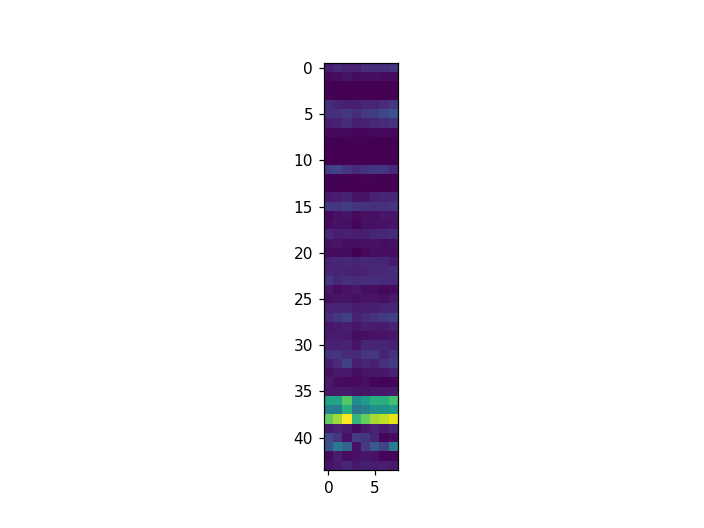

<IPython.core.display.Javascript object>


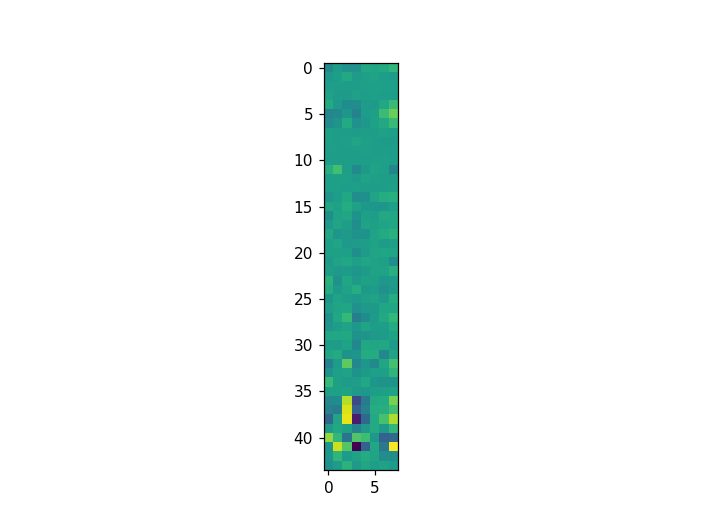

In [231]:
plt.figure()
plt.imshow(da)

#subtract the mean: 
da_c = da-np.array(da.mean(axis=1)).reshape((-1,1)).repeat(8, axis=1)
plt.figure()
plt.imshow(da_c)

In [198]:
task_target_bin_dic[task0,t0,bm,ba,'psth'].loc[n_list,0]

<xarray.DataArray (var: 44)>
array([1.352518e+00, 5.827338e-01, 7.194245e-03, 2.877698e-02, 1.769784e+00,
       3.172662e+00, 1.669065e+00, 4.100719e-01, 1.438849e-02, 0.000000e+00,
       0.000000e+00, 1.884892e+00, 2.158273e-02, 1.438849e-02, 1.388489e+00,
       2.237410e+00, 6.618705e-01, 9.496403e-01, 1.287770e+00, 7.266187e-01,
       4.964029e-01, 1.705036e+00, 1.733813e+00, 1.892086e+00, 6.330935e-01,
       6.618705e-01, 1.589928e+00, 2.402878e+00, 1.079137e+00, 6.474820e-01,
       1.553957e+00, 1.618705e+00, 2.661871e+00, 1.251799e+00, 9.280576e-01,
       1.863309e+00, 2.014388e+00, 1.589928e+00, 2.446043e+00, 2.503597e+00,
       5.035971e-02, 9.014388e+00, 5.035971e-01, 8.633094e-01])
Coordinates:
  * var      (var) |S13 'n_0' 'n_1' 'n_2' 'n_3' ... 'n_40' 'n_41' 'n_42' 'n_43'
    time     int32 0

In [ ]:
                            d0 = task_target_bin_dic[task0,t0,bm,ba,'psth']
                            d1 = task_target_bin_dic[task1,t1,bm,ba,'psth']
                        
                        #ASSIGN:
                        vec_diff_dic[bm, ba, task0, t0, task1, t1] = d0-d1
                        df_i = copy.copy(nan_df)                        
                        
                        #neural diff is over lag 0: 
                        df_i['n_diff_norm'] = np.linalg.norm(d0.loc[n_list,0]-d1.loc[n_list,0])

In [170]:
#For A condition
task0 = 0
t0 = 5
bm = 3
ba = 5

u_true = task_target_bin_dic[task0,t0,bm,ba,'psth'].loc[['u_vx', 'u_vy'],0]
n = task_target_bin_dic[task0,t0,bm,ba,'psth'].loc[n_list,0]
d=bmi_util.decompose_decoder(decoder['F'], decoder['K'])
u_test = np.dot(d['K_d']['v'], n)
vi = np.array([3,5])
print(u_test[vi])
print(u_true)
print('diff:', np.array(u_test[vi]-u_true))


F_hat close to F
K_hat close to K
[0.01210382 2.57197472]
<xarray.DataArray (var: 2)>
array([0.012104, 2.571975])
Coordinates:
  * var      (var) |S13 'u_vx' 'u_vy'
    time     int32 0
('diff:', array([1.00613962e-16, 0.00000000e+00]))


In [165]:
task_target_bin_dic[task0,t0,bm,ba,'psth'].loc[['u_vx', 'u_vy'],0]

<xarray.DataArray (var: 2)>
array([-0.157883,  2.969662])
Coordinates:
  * var      (var) |S13 'u_vx' 'u_vy'
    time     int32 0

In [154]:
decoder.keys()

['A', 'C', 'F', 'K', 'Q', 'W']

In [150]:
decoder['K'].shape

(7L, 44L)

In [155]:
d=bmi_util.decompose_decoder(decoder['F'], decoder['K'])

F_hat close to F
K_hat close to K


In [159]:
d['K_d']['v'].shape

(7L, 44L)

In [ ]:
#FOR REFERENCE: 
#accumulate the differences: 
min_trials_analyze = 15
max_mag=3

#sel: 
num_trials0_sel = (diff_df['num_trials0']>=min_trials_analyze) #5
num_trials1_sel = (diff_df['num_trials1']>=min_trials_analyze) #5
mag_sel = (diff_df['mag_bin']<=max_mag)

sel_universal = \
    num_trials0_sel\
    &num_trials1_sel\
    &mag_sel

move_sel_dic = {}
move_list = ['within_move', 'within_task', 'within_co', 'within_obs', 'across_task', 'across_move']
move_sel_dic['within_move', 'sel'] = (diff_df['target0']==diff_df['target1'])&(diff_df['task0']==diff_df['task1'])
move_sel_dic['within_task', 'sel'] = (diff_df['target0']!=diff_df['target1'])&(diff_df['task0']==diff_df['task1'])
move_sel_dic['within_co', 'sel'] = (diff_df['target0']!=diff_df['target1'])&(diff_df['task0']==diff_df['task1'])&(diff_df['task0']==0)
move_sel_dic['within_obs', 'sel'] = (diff_df['target0']!=diff_df['target1'])&(diff_df['task0']==diff_df['task1'])&(diff_df['task0']==1)
move_sel_dic['across_task', 'sel'] = (diff_df['task0']!=diff_df['task1'])
move_sel_dic['across_move', 'sel'] = (diff_df['task0']!=diff_df['task1'])|(diff_df['target0']!=diff_df['target1'])

for move in move_list: 
    sel = sel_universal\
    &move_sel_dic[move,'sel']
    move_sel_dic[move, 'n_diff'] = diff_df.loc[sel,'n_diff_norm']
    move_sel_dic[move, 'b_diff'] = diff_df.loc[sel,'b_diff_norm']
    move_sel_dic[move, 'b_diff_lag0'] = diff_df.loc[sel,'b_diff_norm_lag0']
    
    